## Import libraries

In [ ]:
# !pip install numba-progress

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from tqdm import trange, tqdm
from numba.typed import List
from numba_progress import ProgressBar

## Initialization and supplementary functions

In [ ]:
def adj_matrix(maxweight:int = 10, size: int = 100):
    '''
    adj: 2D adjacency matrix of a weighted graph
    neighbors: list of lists of neighbors indexes
    '''
    adj = np.random.randint(0, maxweight, (size, size))
    for i in range(100):
        for j in range(i):
            adj[i,j] = adj[j,i]
    adj = np.where(adj==0, np.infty, adj)
    for i in range(100):
        adj[i,i]=0
    neighbors = List()
    for i in range(100):
        neighbors_ = List()
        for j in range(100):
            if i != j and adj[i,j] != np.infty:
                neighbors_.append(j)
        neighbors.append(neighbors_)
    return adj, neighbors

In [ ]:
#global variables
N = 100//4 # number of particles
n = 100 # number of nodes

def system_initialization(N:int = 100//4,maxweight:int = 10, size:int = 100):
    '''
    N - number of particles
    particles: ndarray of particles' indexes 
    is_particle: ndarray stating wether a node has a particle or it's vacant
    '''
    adj, neighbors = adj_matrix(maxweight = 10, size = 100)
    particles = np.arange(0,N)
    is_particle = np.zeros(size, dtype=bool)
    is_particle[:N] = 1
    return N, adj, neighbors, particles, is_particle

@njit
def one_particle_energy(particle_number, particles, is_particle, neighbors, adj, eps=1, sigma=1):
    E = 0
    node_number = particles[particle_number]
    # determine neighbors
    for i in range(len(neighbors[node_number])):
        neighbor = neighbors[node_number][i]
        # add energy for every neighbor
        if is_particle[neighbor]:
            weight = adj[node_number, neighbor]
            E += 4*eps*((sigma/weight)**12-(sigma/weight)**6)
    return E

@njit
def total_energy(particles, is_particle, neighbors, adj, eps, sigma):
    E_tot = 0
    for i in range(N):
        E_tot += one_particle_energy(i, particles, is_particle, neighbors, adj, eps, sigma)
    return E_tot/2

## Metropolis algorithm

In [ ]:
@njit
def step(particles, is_particle, E_tot, Statistic, neighbors, adj, eps, sigma):
    '''
    one step of a cycle:
    main part of the metropois algorithm, consists of
    1. shifting one random particle to the neigboring node
    2. calculating the difference in energy
    3. accepting\rejecting new location of the particle
    '''

    #calculate new coordinates
    choice = np.random.choice
    old_particle_number = choice(np.arange(N))
    old_node_number = particles[old_particle_number]
    if len(neighbors[old_node_number]) != 0:
        neighboring_loc = choice(np.arange(len(neighbors[old_node_number])))
        neighbor = neighbors[old_node_number][neighboring_loc]
    else:
        Statistic[0] +=1
        return particles, is_particle, E_tot, Statistic

    # if new location is already occupied, skip
    if is_particle[neighbor]:
        Statistic[1] +=1
        return particles, is_particle, E_tot, Statistic
    # old energy
    E_old = one_particle_energy(old_particle_number, particles, is_particle, neighbors, adj, eps, sigma)
    #shift the particle
    is_particle[old_node_number] = 0
    is_particle[neighbor] = 1
    particles_new = np.delete(particles, old_particle_number) 
    particles_new = np.append(particles_new, neighbor)
    # new energy
    E_new = one_particle_energy(N-1, particles_new, is_particle, neighbors, adj, eps, sigma)
    
    dE = E_new-E_old
    # accept/reject
    dp = np.exp(-dE)
    # accept
    if dp > np.random.random():
        E_tot += dE
        Statistic[2] +=1
        return particles_new, is_particle, E_tot, Statistic

    # reject
    else:
        #return the particle back
        Statistic[3] +=1
        is_particle[old_node_number] = 1
        is_particle[neighbor] = 0
        return particles, is_particle, E_tot, Statistic

In [ ]:
@njit
def cycle(particles, is_particle, E_tot, neighbors, adj, steps, eps, sigma, progress_proxy):
    '''
    cycle of metropolis algorithm's steps
    stores information about energy levels during the simulation
    '''
    Statistic = [0., # 'no_neighbors'
                 0., # 'occupied'
                 0., # 'accepted'
                 0.] # 'rejected'
    E_arr = []
    time_arr = []
    for i in np.arange(1,steps+1):
        particles, is_particle, E_tot, Statistic = step(particles, is_particle, E_tot, Statistic, neighbors, adj, eps, sigma)
        # if steps<10**4 or i%(steps//10**4) == 0:
        E_arr.append(E_tot)
        time_arr.append(i+1)
        progress_proxy.update(1)
    for i in range(4):
        Statistic[i] /= steps

    return particles, is_particle, E_arr, E_tot, time_arr, Statistic

In [ ]:
def simulation(progress, eps, sigma, N, adj, neighbors, particles, is_particle, steps=10**5):
    '''
    does the simulation and returns numerical results
    '''
    E_tot = total_energy(particles, is_particle, neighbors, adj, eps, sigma)
    print('\nE_start = {:<2.4f}'.format(E_tot))
    particles, is_particle, E_arr, E_tot, time_arr, Statistic =\
        cycle(particles, is_particle, E_tot, neighbors, adj, steps, eps, sigma, progress)

    E_fin = total_energy(particles, is_particle, neighbors, adj, eps, sigma)
    print('E_end = {:<2.4f}'.format(E_fin))
    assert np.isclose(E_fin, E_tot), f'E_fin={E_fin}, E_tot={E_tot}'

    return particles, is_particle, E_arr, time_arr, Statistic

In [ ]:
def show_and_save_results(eps, sigma,E_arr, time_arr, Statistic, steps):
    '''
    visualizes the numerical data
    '''
    # plot graphs
    value = E_arr
    values_name = r'$E$'
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
    fig.suptitle(r"steps = {:<2.0e},$\varepsilon=${:2.2f}, $\sigma=${:2.3f}, success rate  = {:<1.3f}, rejection rate  = {:<1.3f}, node was occupied: {:<1.3f}, didn't have neighbours:{:<1.2e}".format(
        steps, eps, sigma, Statistic[2],Statistic[3],Statistic[1],Statistic[0]), fontsize=20)
    ax.plot(time_arr, value)
    ax.set_ylabel(values_name,fontsize=16)
    ax.set_xlabel('steps',fontsize=16)
    plt.show()
    # save results

    # with open('steps_{:1.0e}.npy'.format(steps), 'wb') as f:
    #     np.save(f, particles)
    #     np.save(f, is_particle)
    #     np.save(f, E_arr)
    #     np.save(f, time_arr)
    #     np.save(f, np.array([steps, succ_rate]))

## Results

### $σ=1,ɛ∈[0,50]$

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 0.0000
E_end = 0.0000


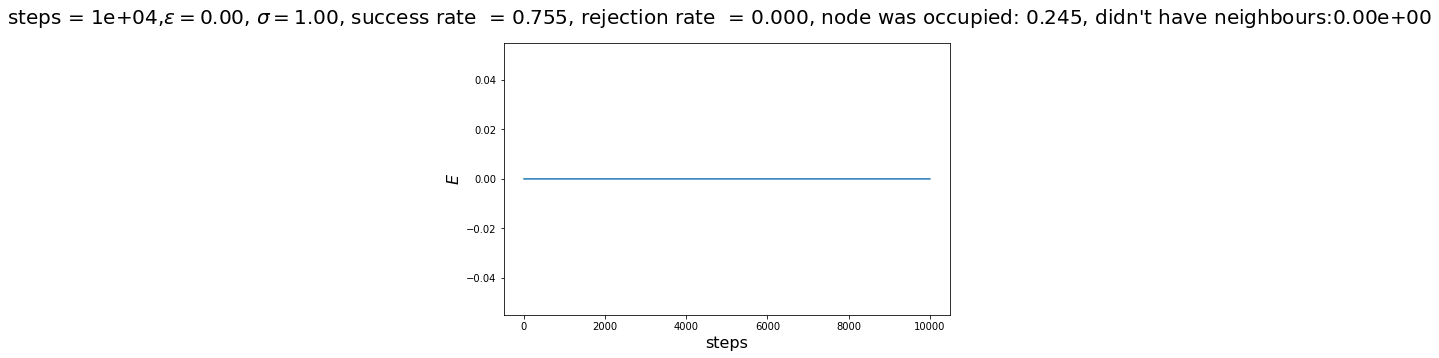

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -5.4057
E_end = -4.9449


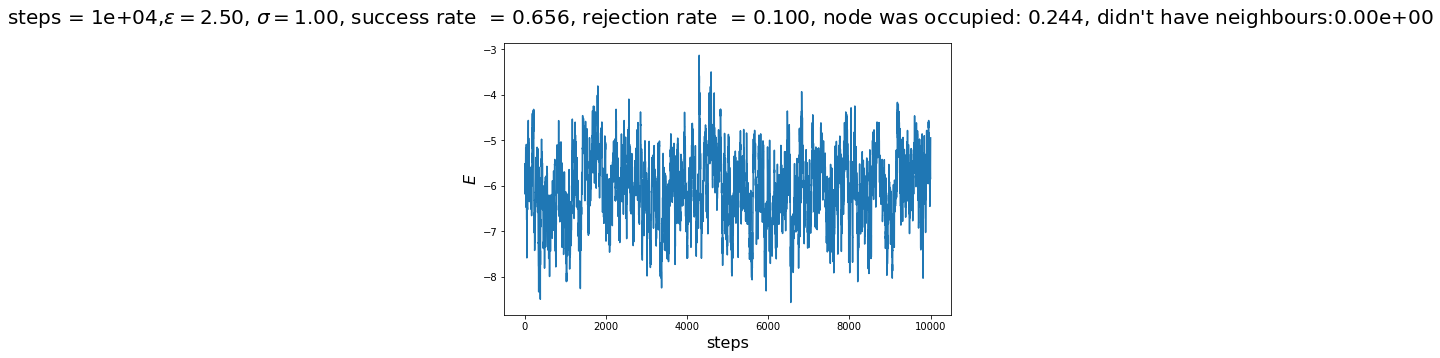

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -10.8114
E_end = -12.8363


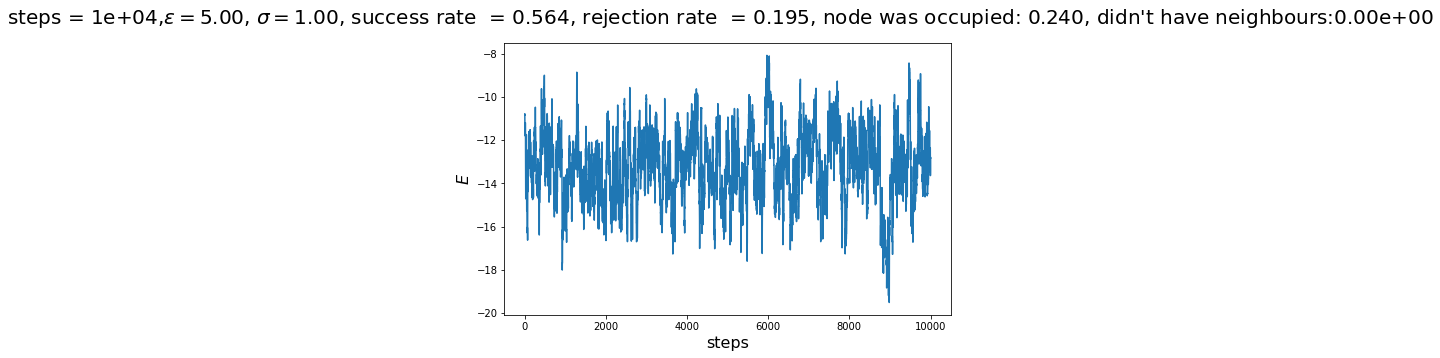

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -16.2171
E_end = -25.3115


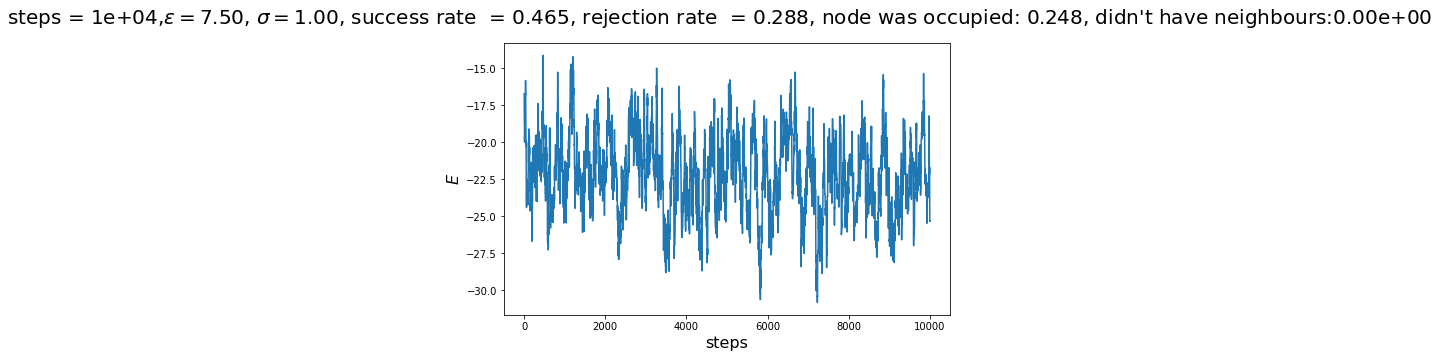

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -21.6228
E_end = -31.1982


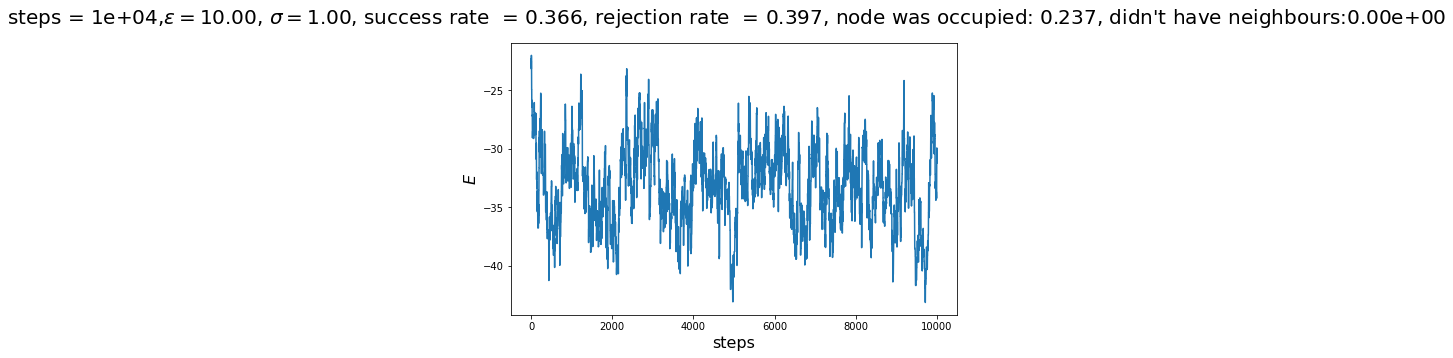

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -27.0285
E_end = -50.5573


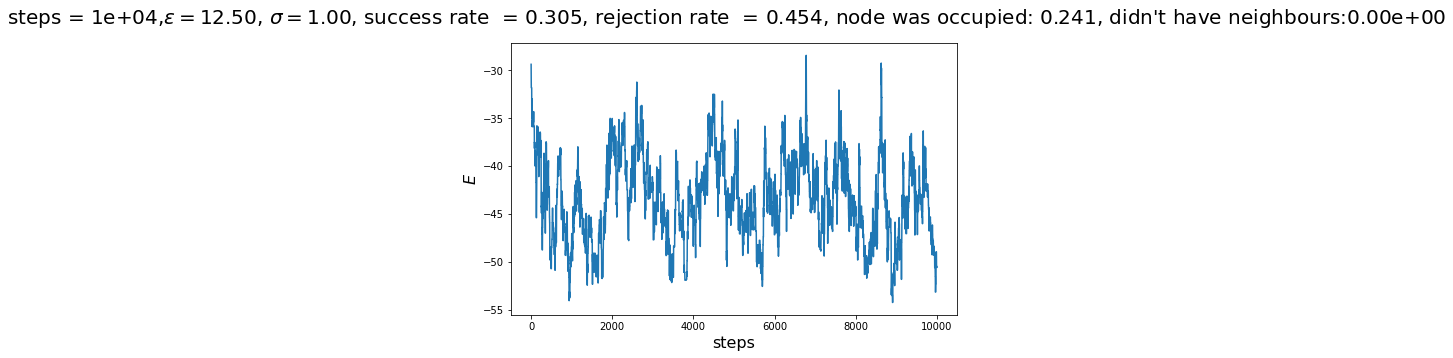

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -32.4342
E_end = -57.3133


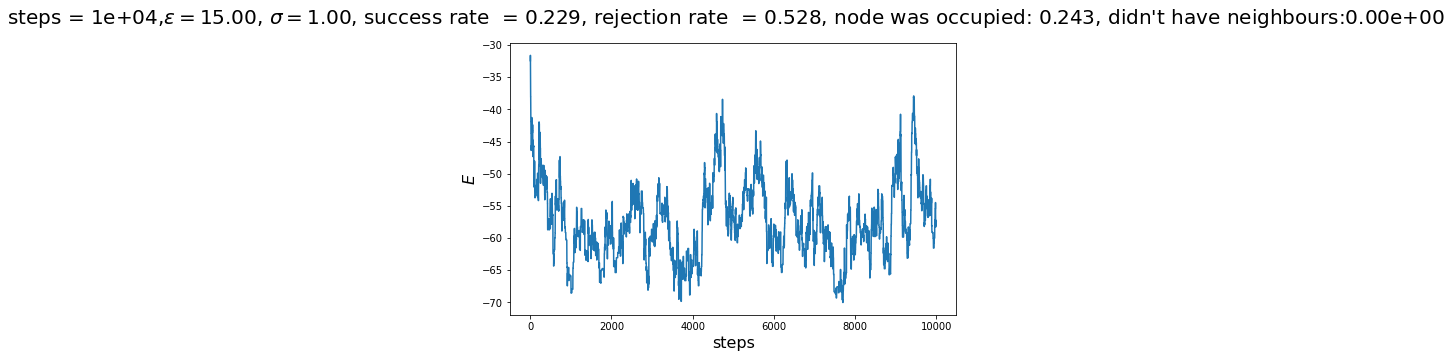

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -37.8400
E_end = -69.2105


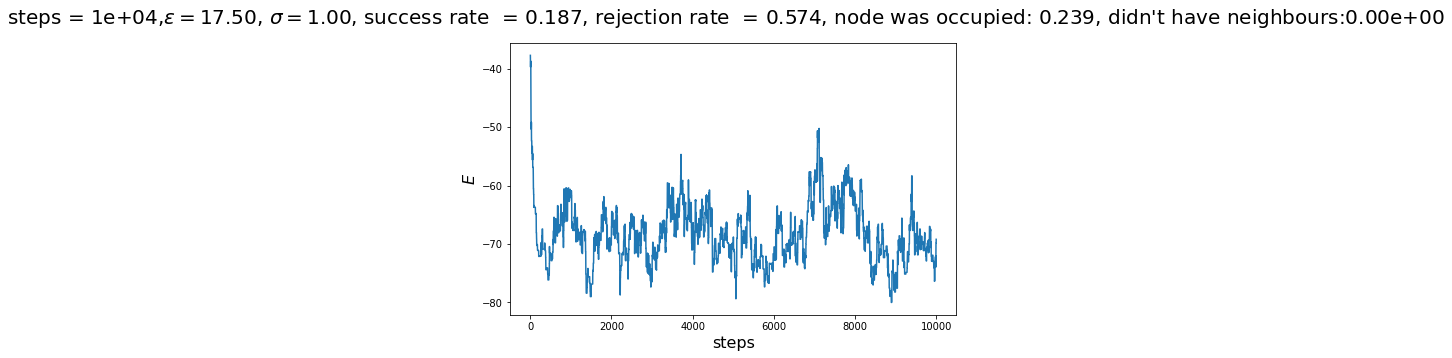

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -43.2457
E_end = -80.6919


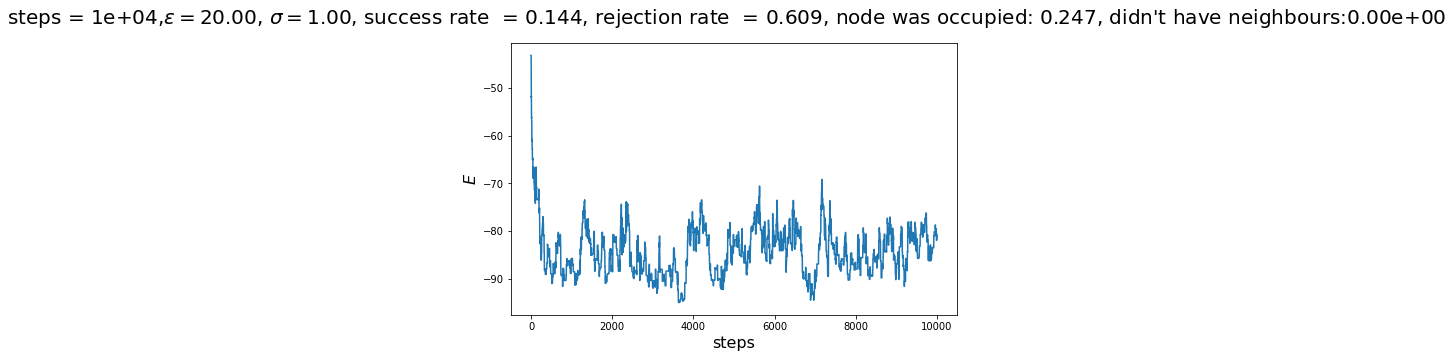

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -48.6514
E_end = -101.2078


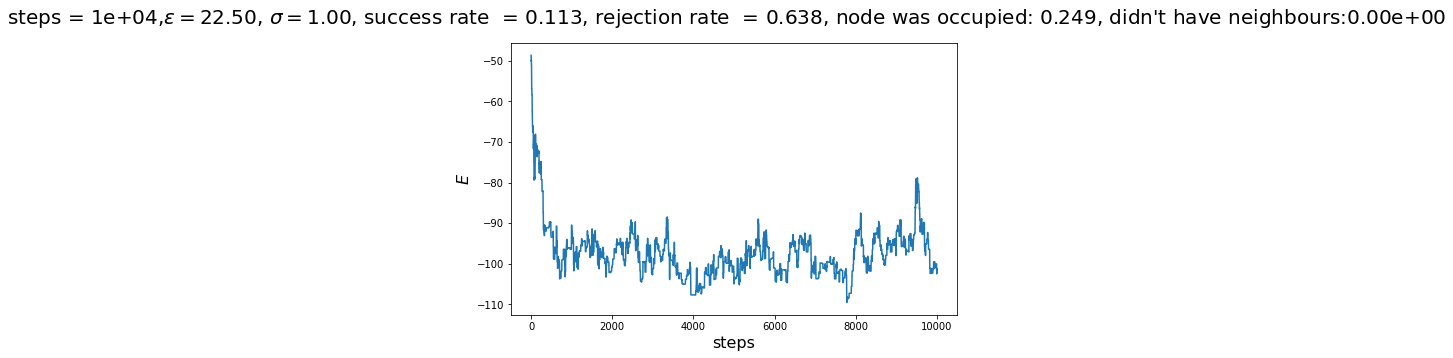

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -54.0571
E_end = -117.6347


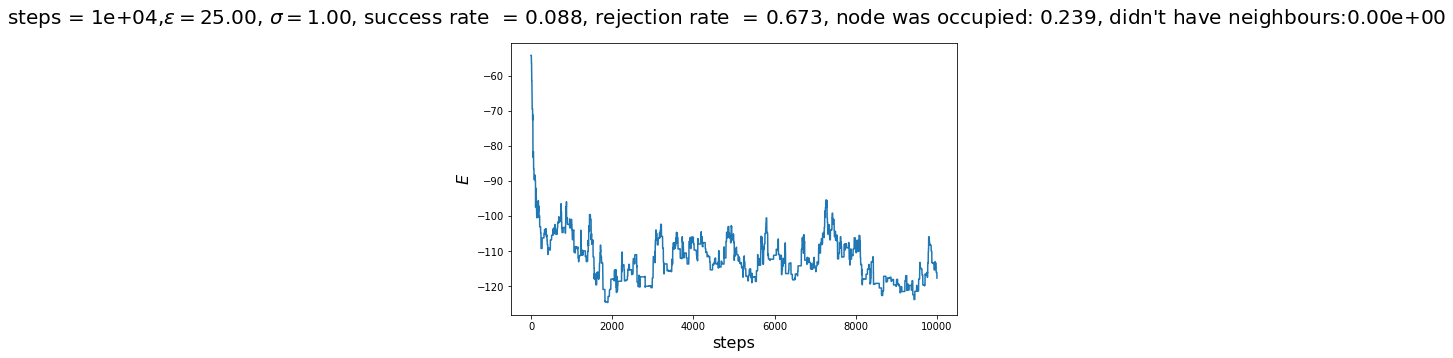

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -59.4628
E_end = -128.7057


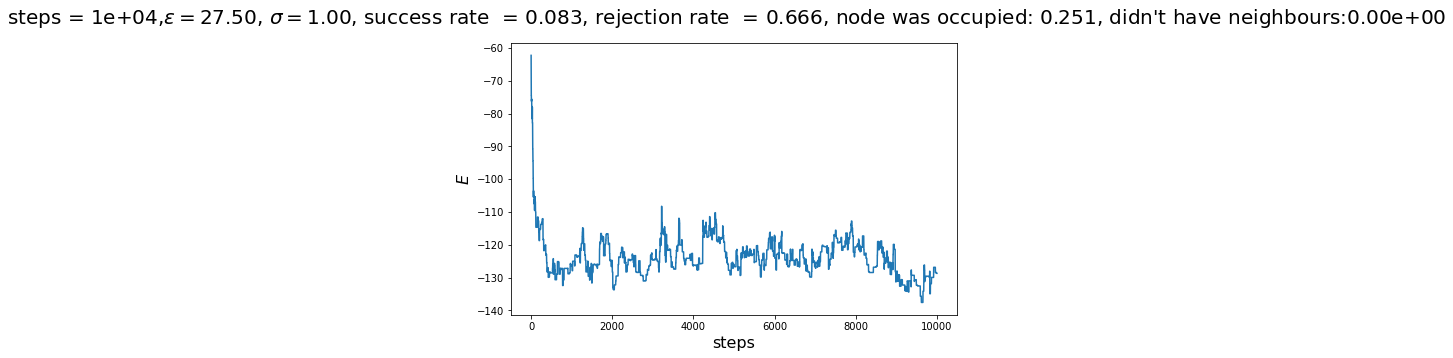

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -64.8685
E_end = -146.0082


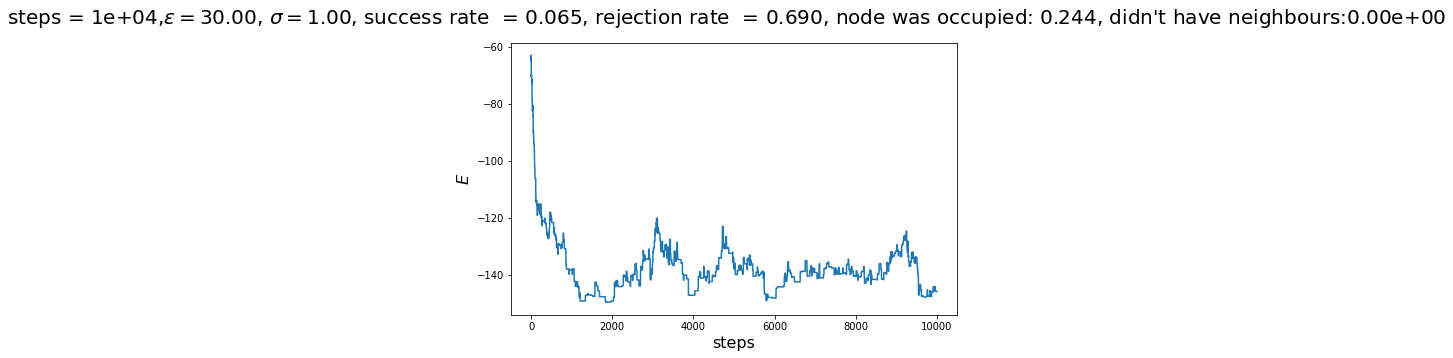

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -70.2742
E_end = -152.1961


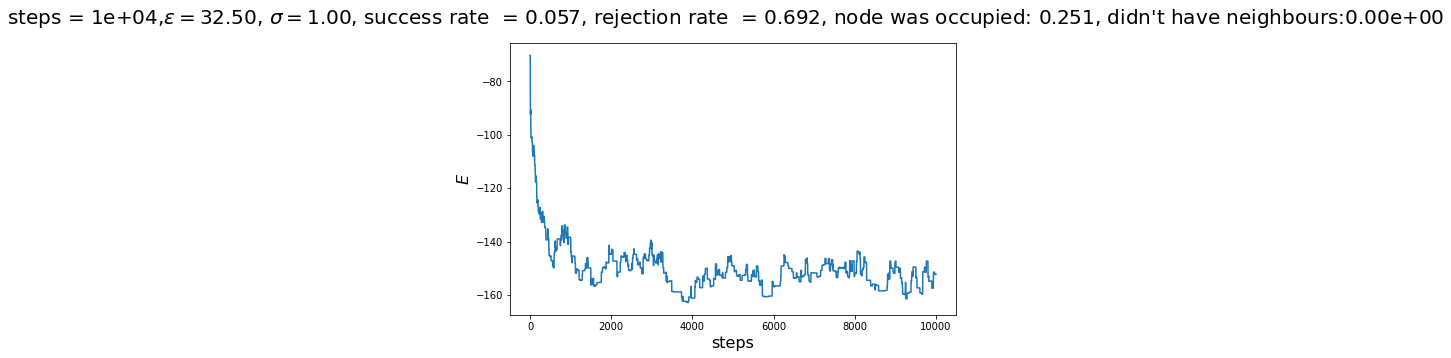

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -75.6799
E_end = -174.0441


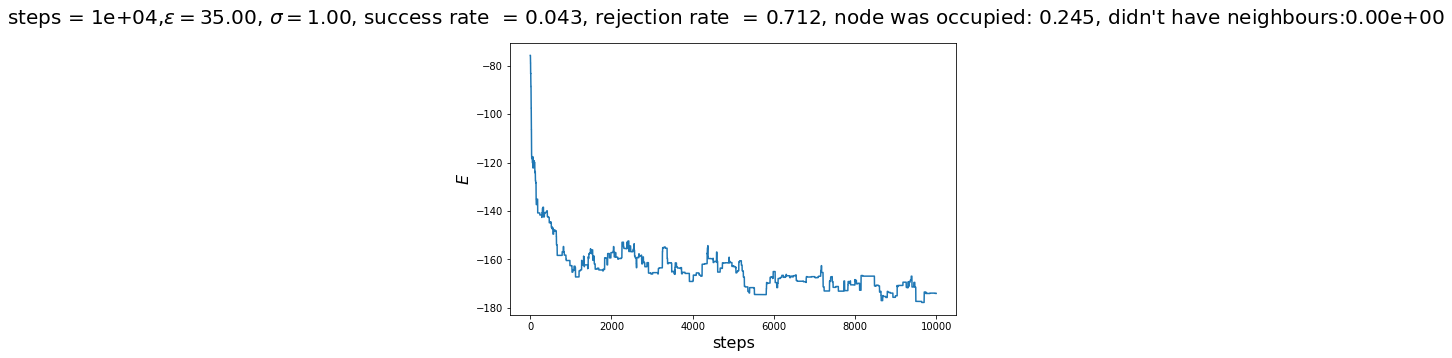

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -81.0856
E_end = -181.4684


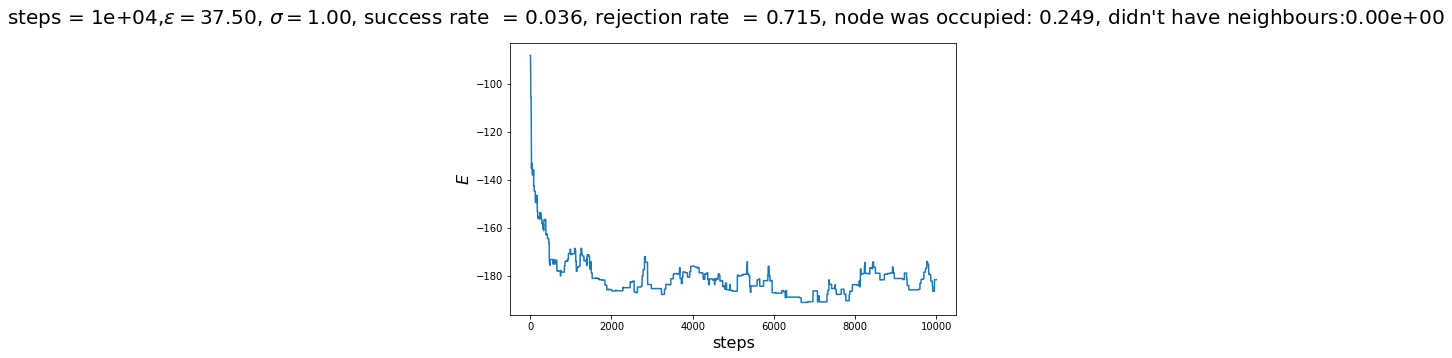

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -86.4913
E_end = -192.8066


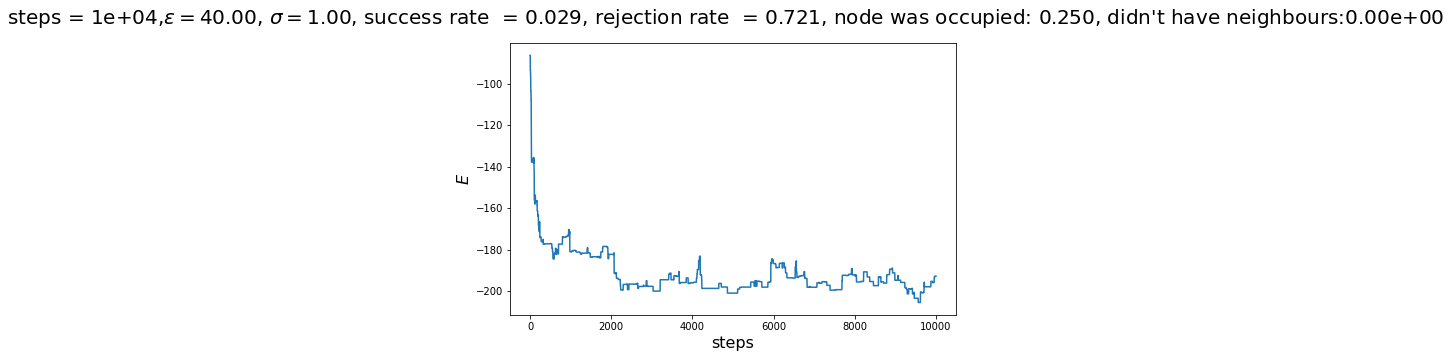

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -91.8970
E_end = -216.3693


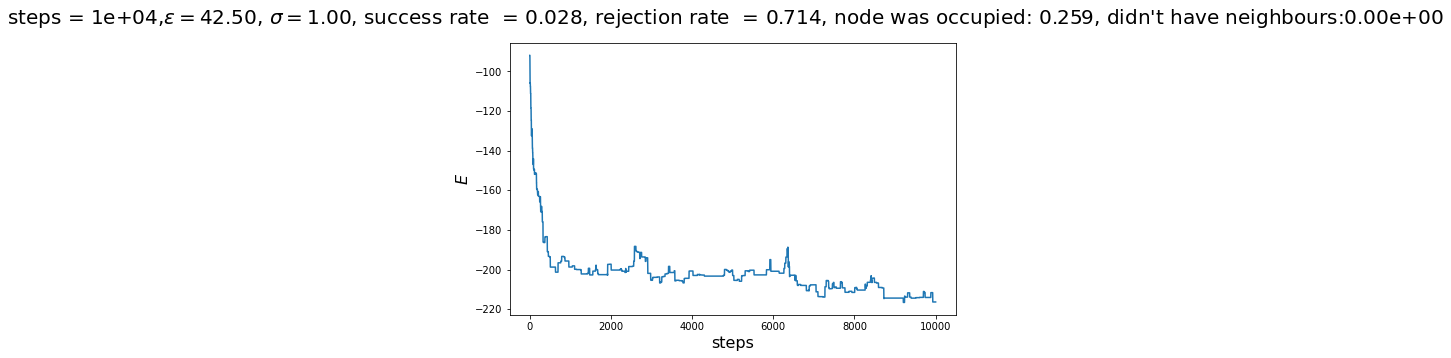

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -97.3027
E_end = -224.0722


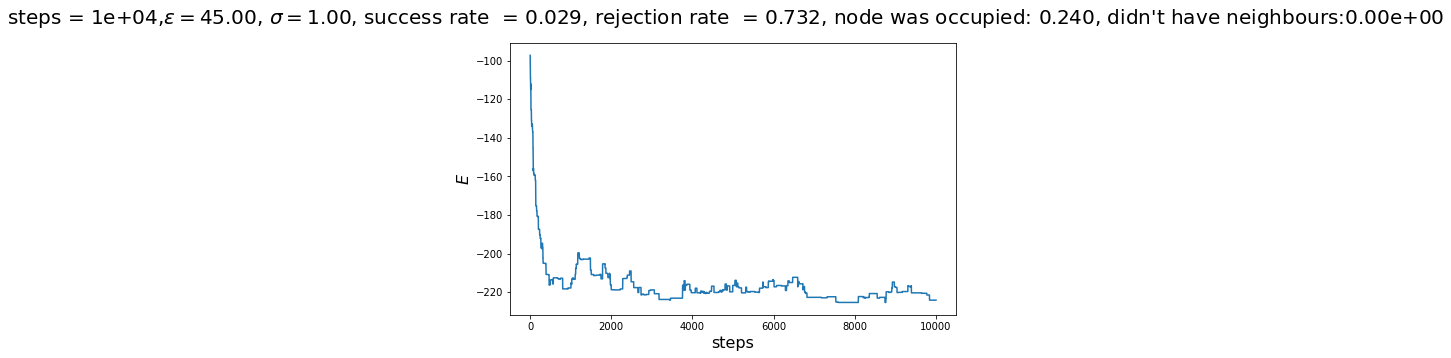

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -102.7084
E_end = -236.4323


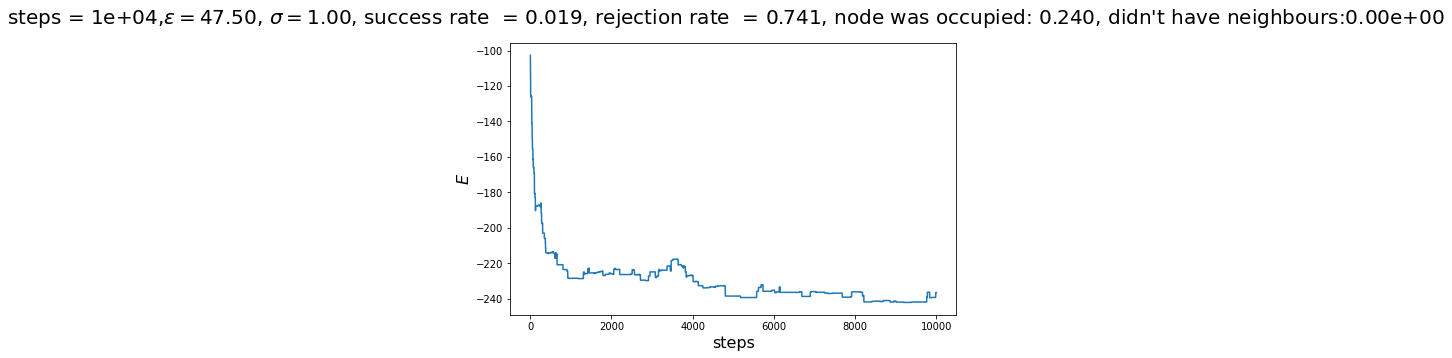

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -108.1142
E_end = -251.5213


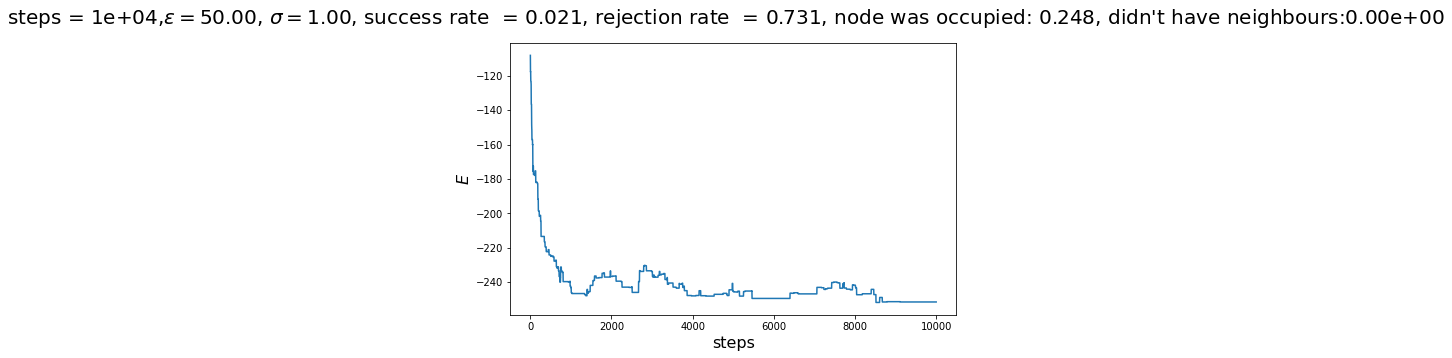

In [ ]:
steps = 10**4
sigma = 1
Succ_rate = []
Rej_rate = []
N, adj, neighbors, particles_init, is_particle_init =\
        system_initialization(N = 100//4,maxweight = 10, size = 100)
for eps in np.arange(0,51, 2.5):
    particles, is_particle = particles_init.copy(), is_particle_init.copy()
    with ProgressBar(total=steps) as progress:
        particles, is_particle, E_arr, time_arr, Statistic = simulation(progress, eps, sigma, N, adj, neighbors, particles, is_particle, steps)
    Succ_rate.append(Statistic[2])
    Rej_rate.append(Statistic[3])
    show_and_save_results(eps, sigma,E_arr, time_arr, Statistic, steps)

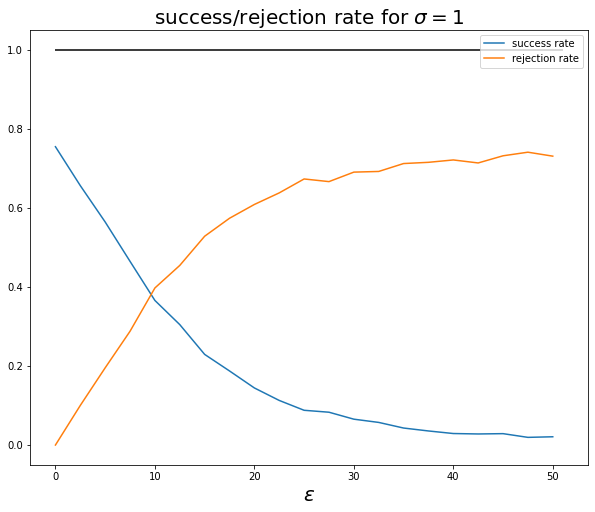

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,51, 2.5), Succ_rate, label='success rate')
plt.plot(np.arange(0,51, 2.5), Rej_rate, label='rejection rate')
plt.hlines(1, 0, 51)
plt.legend()
plt.xlabel(r'$\varepsilon$', fontsize=20)
plt.title(r'success/rejection rate for $\sigma=1$', fontsize=20)
plt.show()

### $σ\in[0,2],ɛ=20$

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 0.0000
E_end = 0.0000


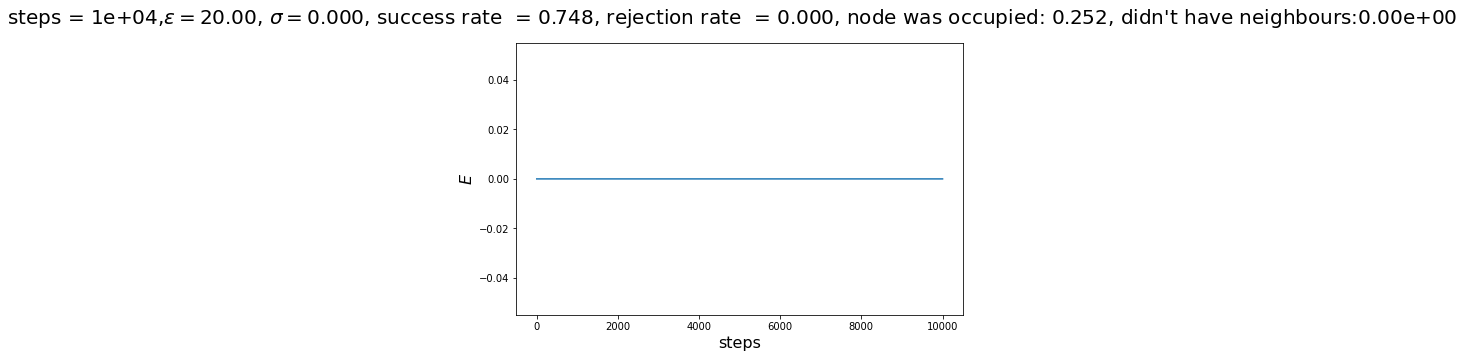

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -0.0000
E_end = -0.0000


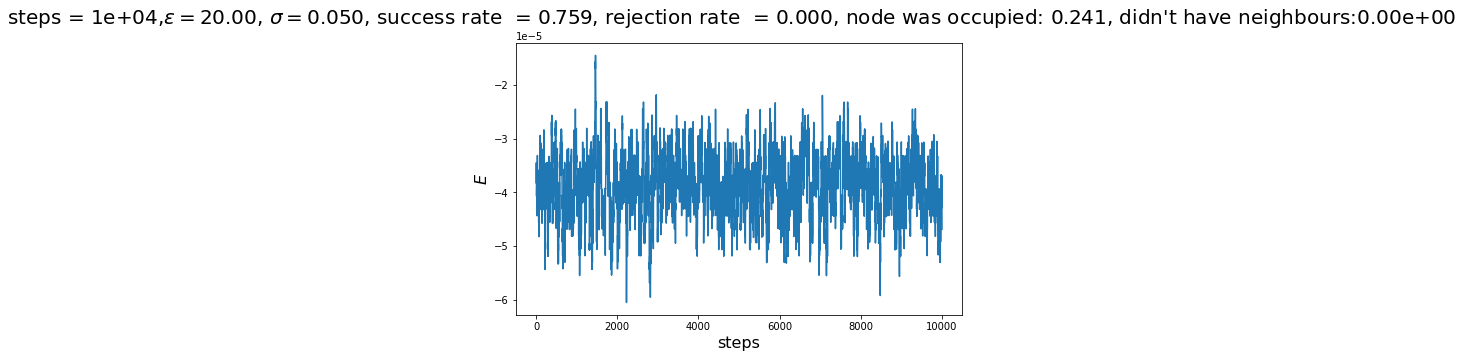

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -0.0025
E_end = -0.0022


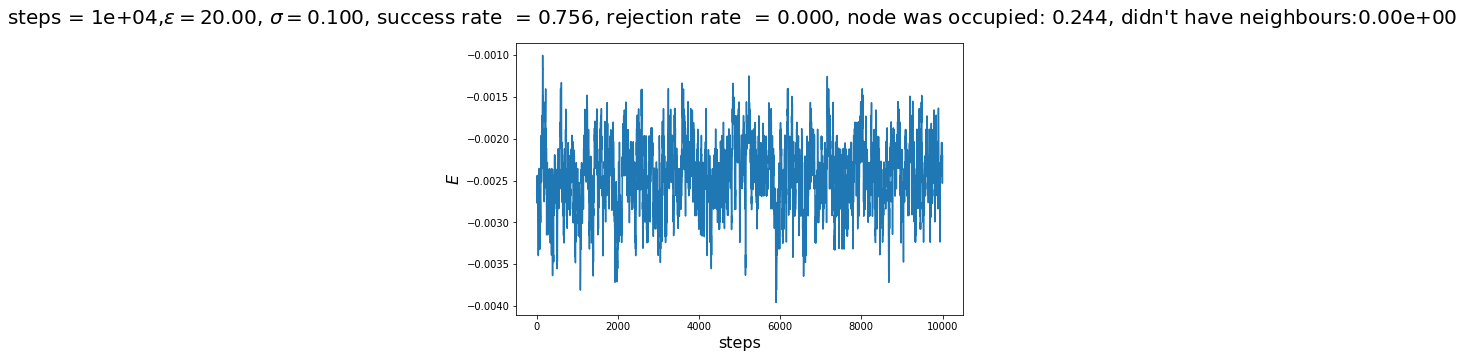

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -0.0288
E_end = -0.0333


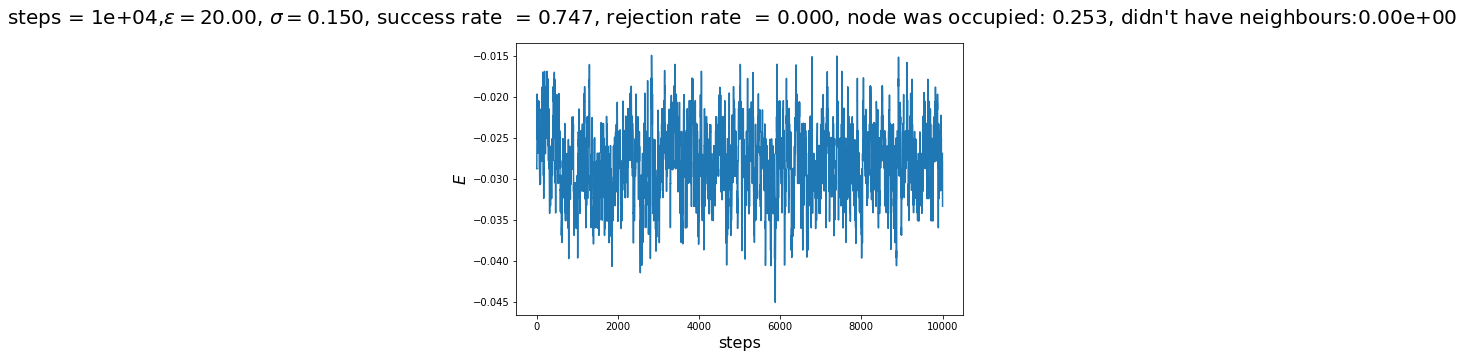

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -0.1616
E_end = -0.1612


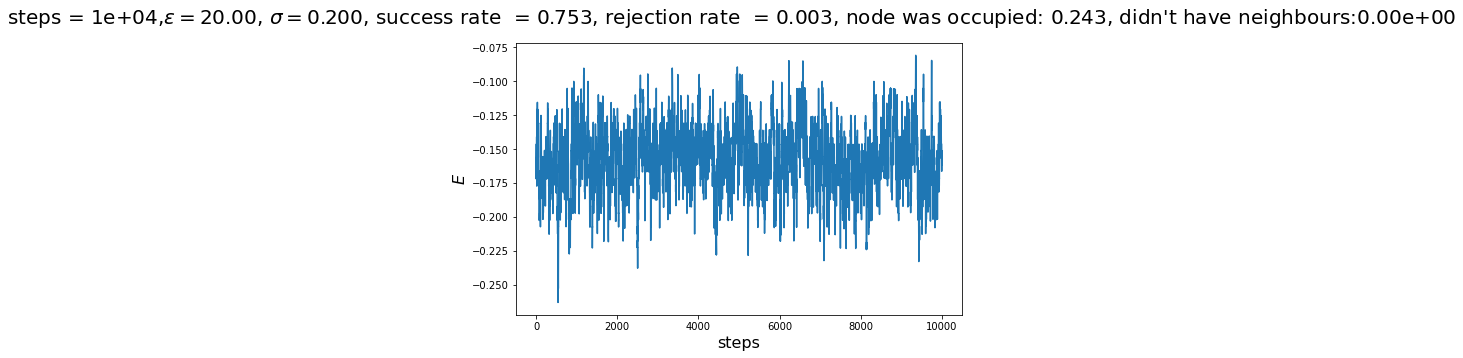

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -0.6165
E_end = -0.4024


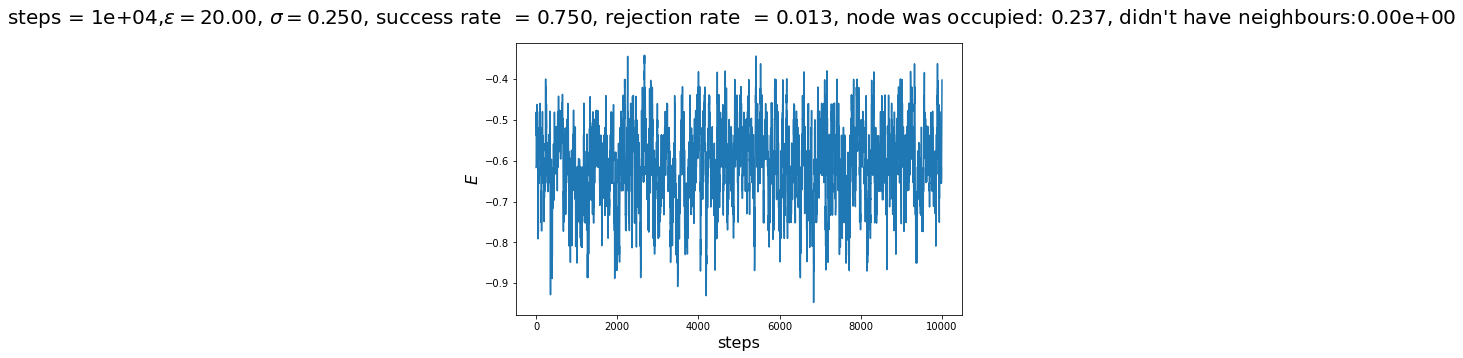

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -1.8399
E_end = -1.8995


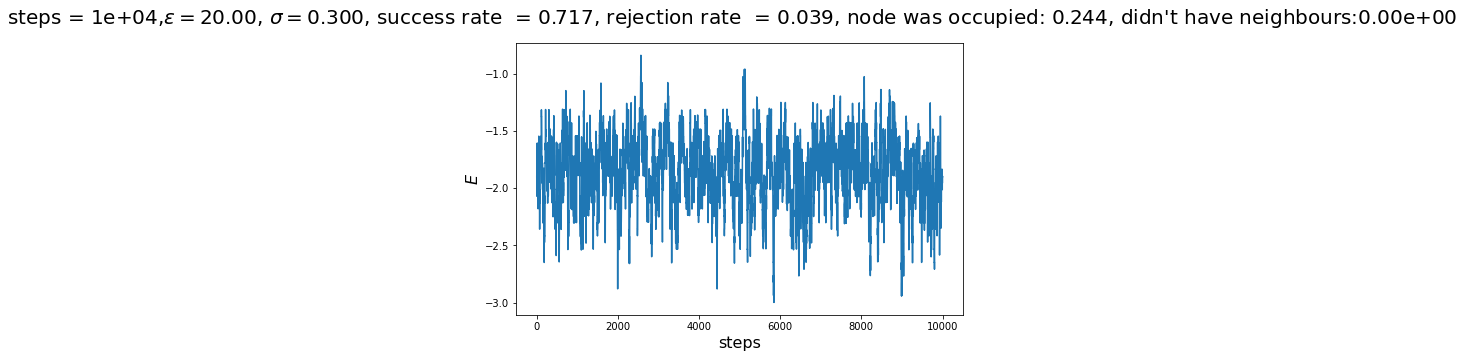

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -4.6346
E_end = -6.5441


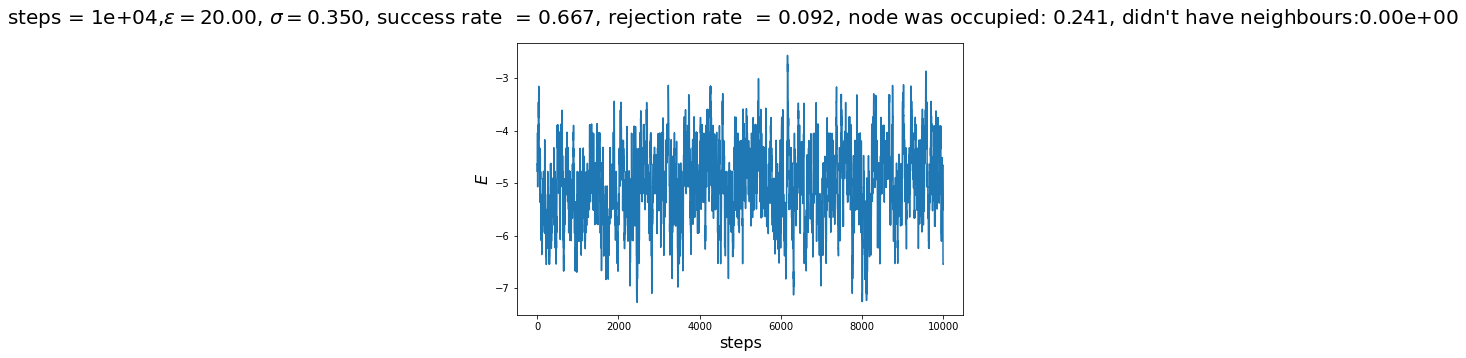

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -10.3037
E_end = -9.9322


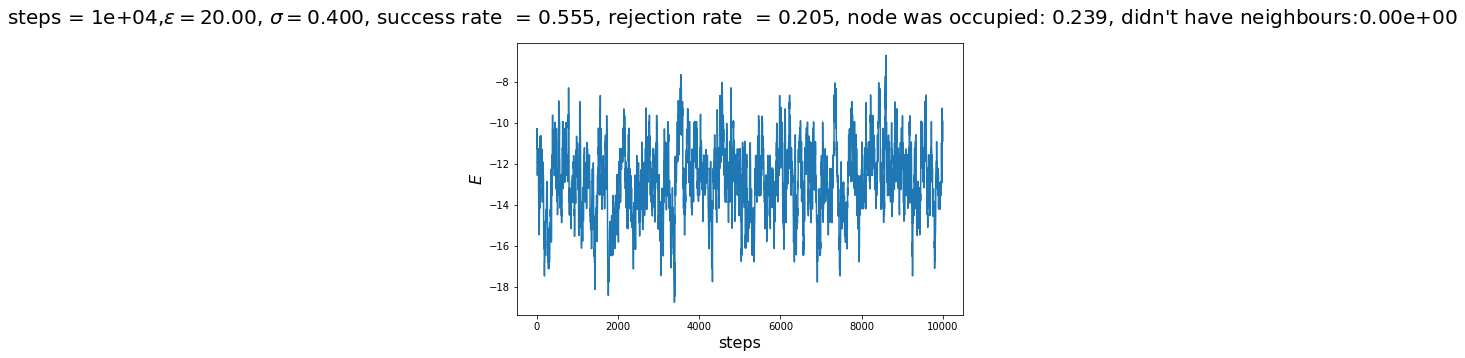

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -20.8019
E_end = -36.5877


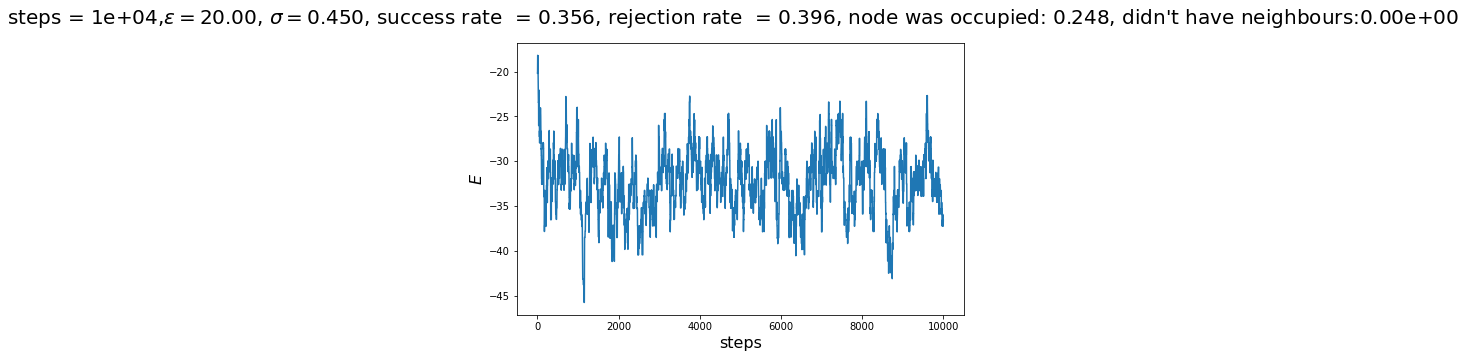

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -38.8587
E_end = -84.0923


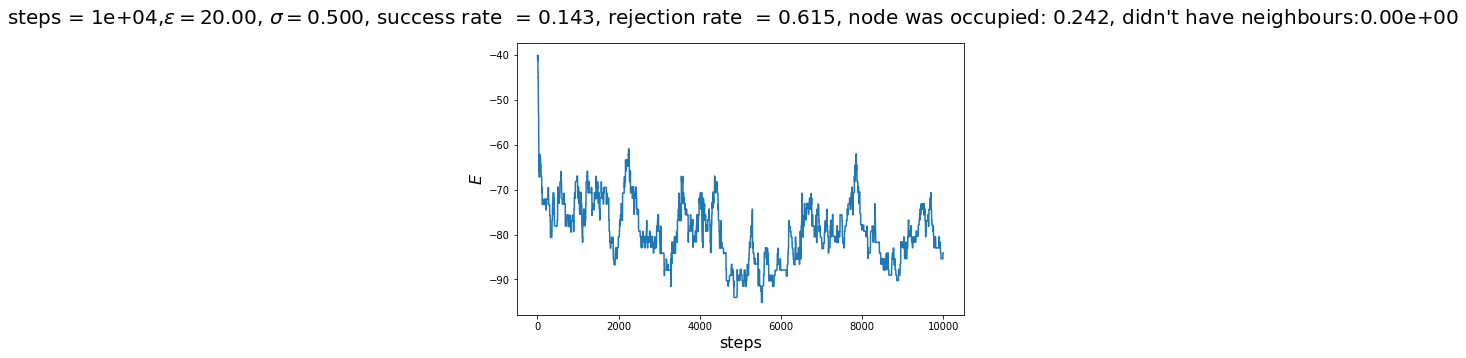

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -68.0127
E_end = -164.5340


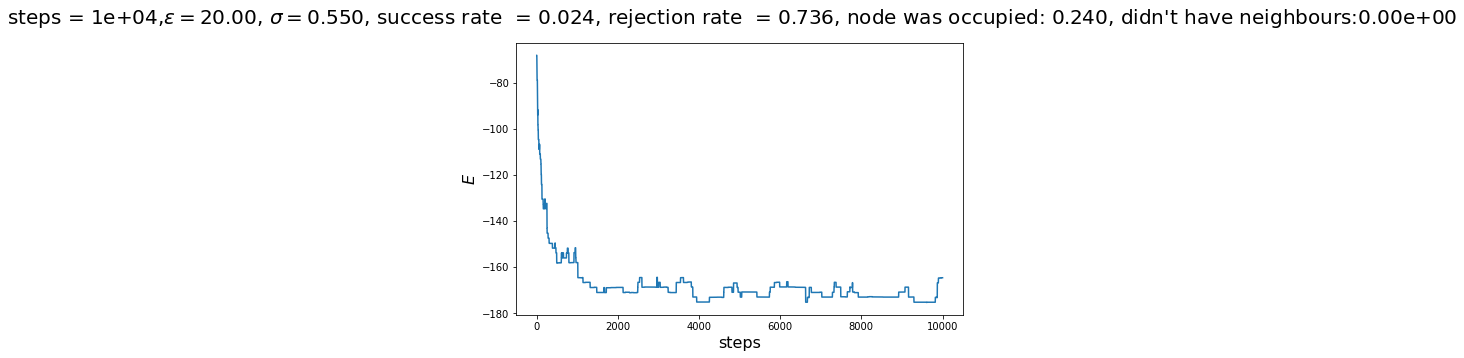

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -112.4400
E_end = -261.1665


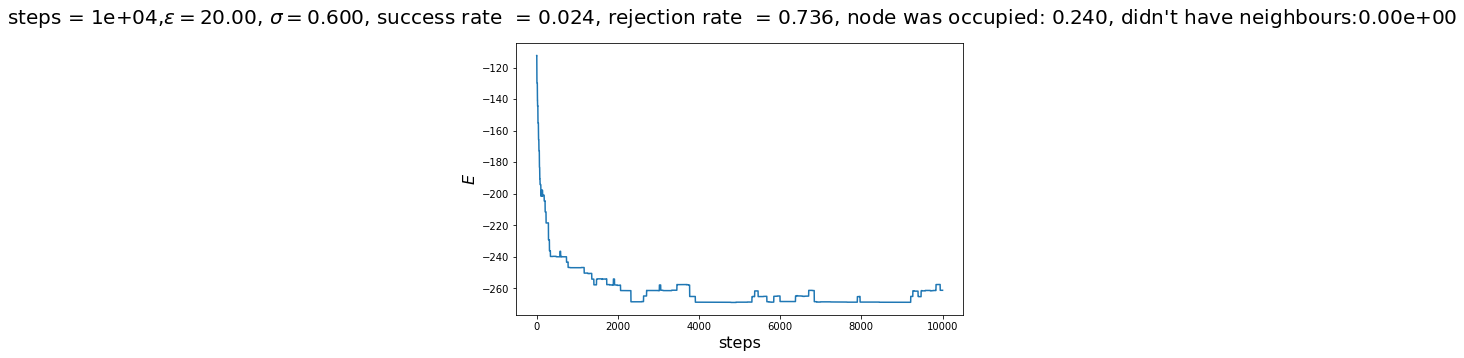

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -176.3767
E_end = -426.6448


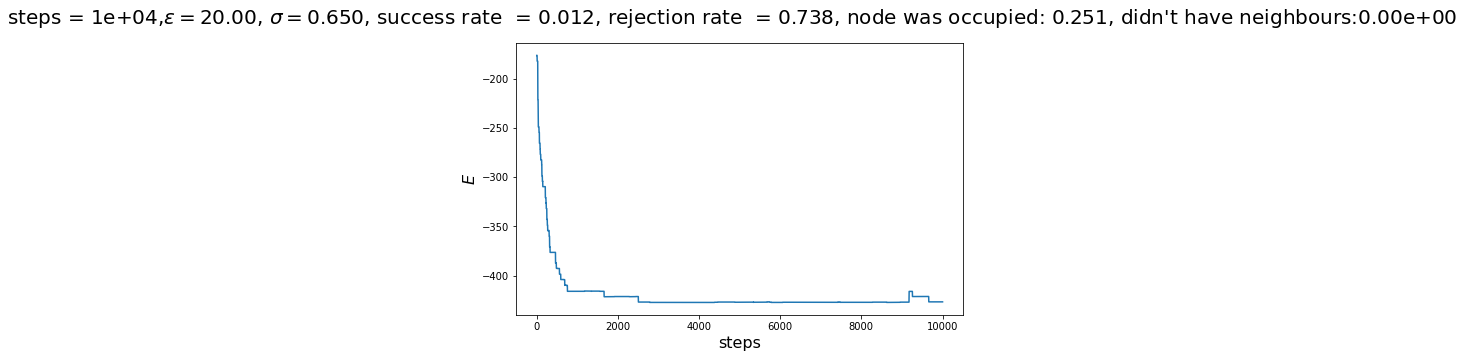

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -262.8125
E_end = -634.5734


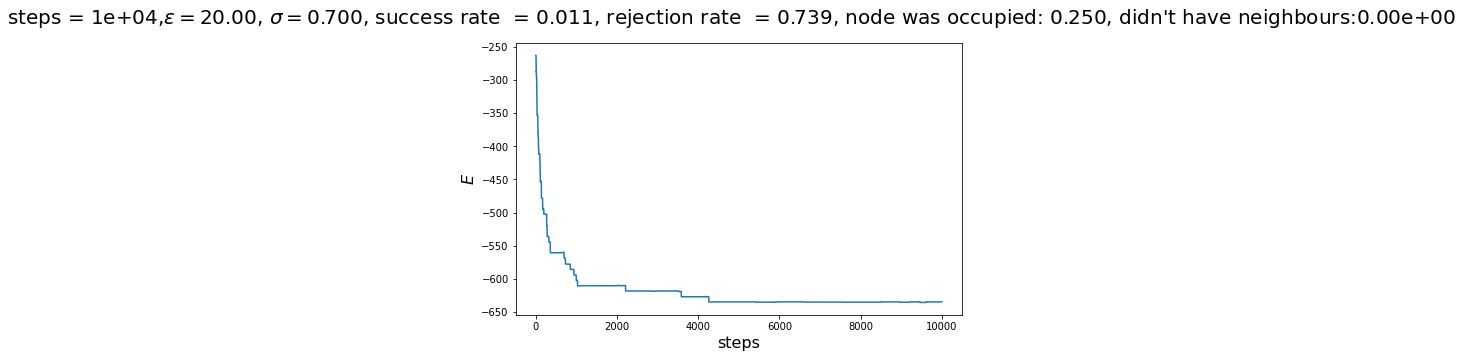

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -370.9452
E_end = -953.3054


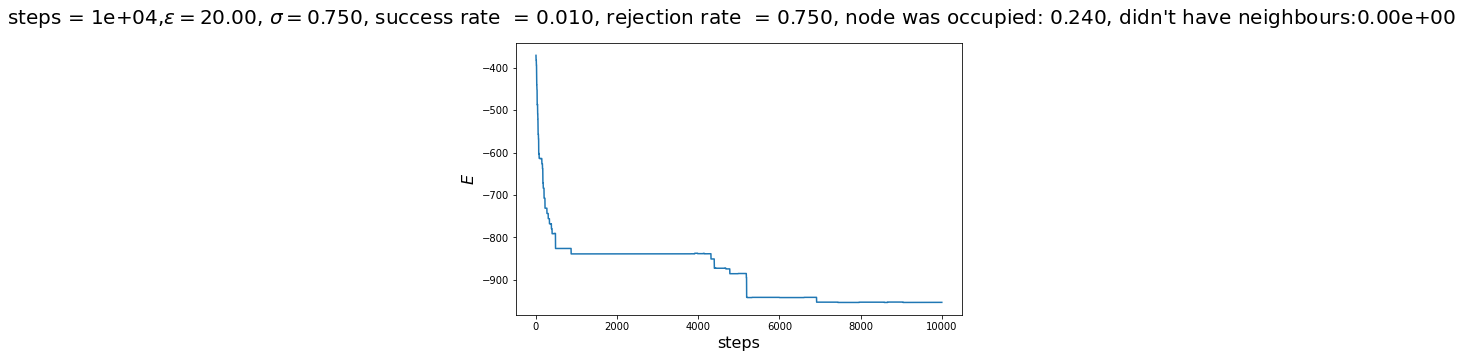

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -491.6323
E_end = -1169.1323


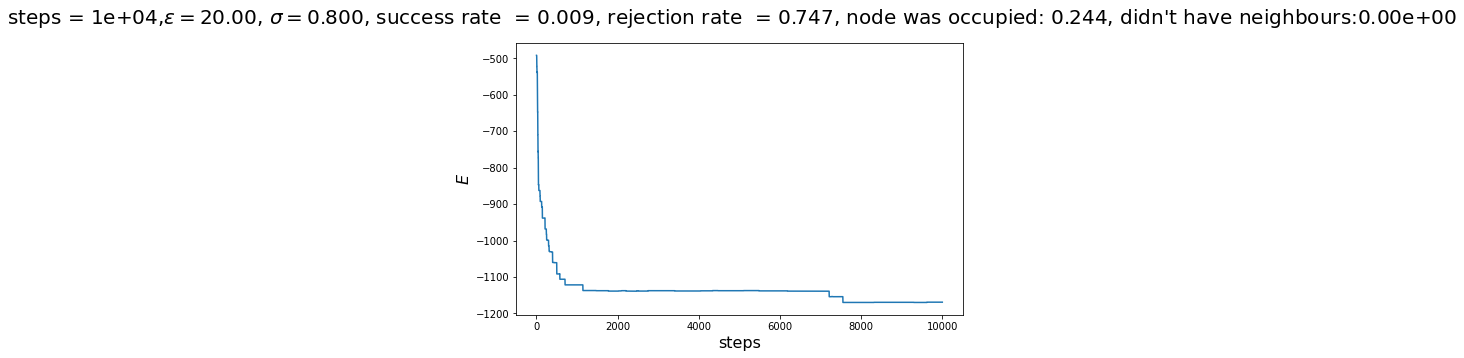

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -599.7205
E_end = -1421.7530


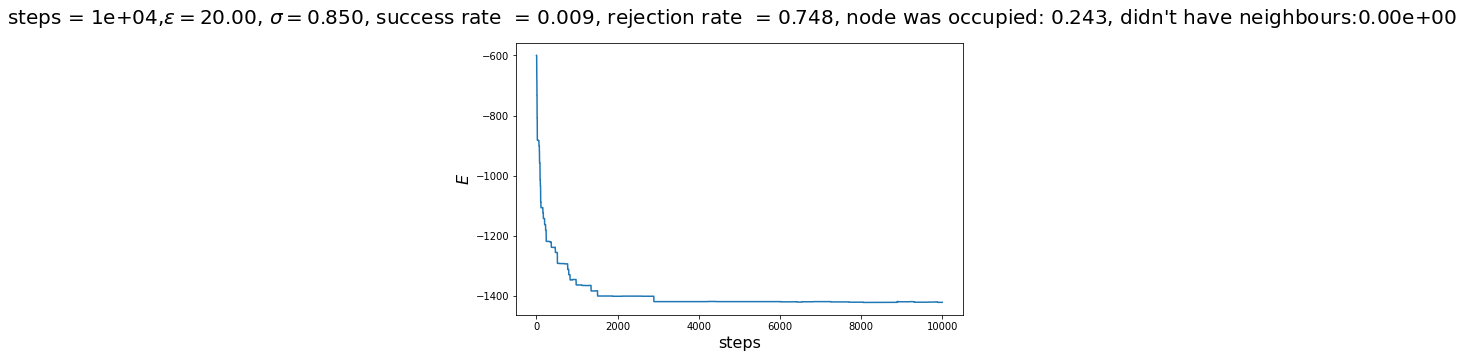

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -641.6602
E_end = -1629.2450


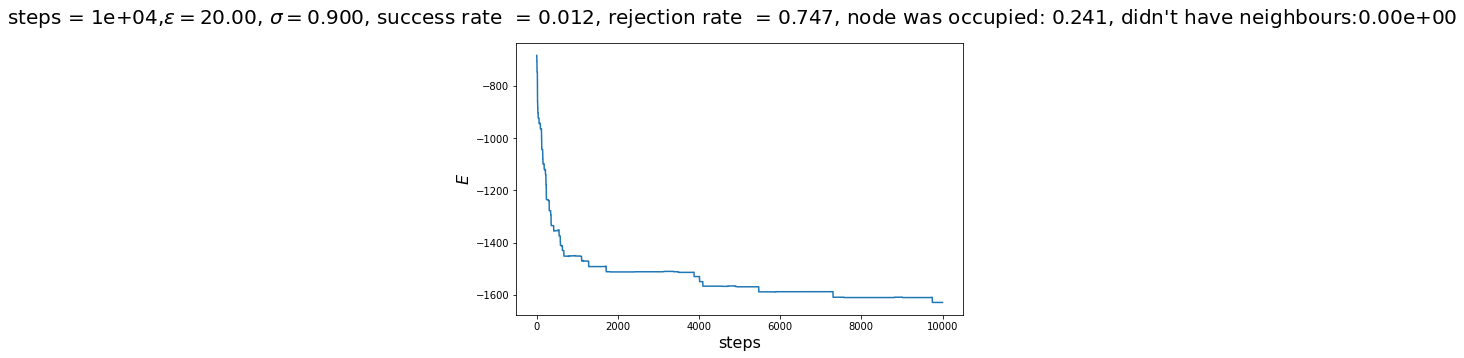

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -516.1891
E_end = -1284.2525


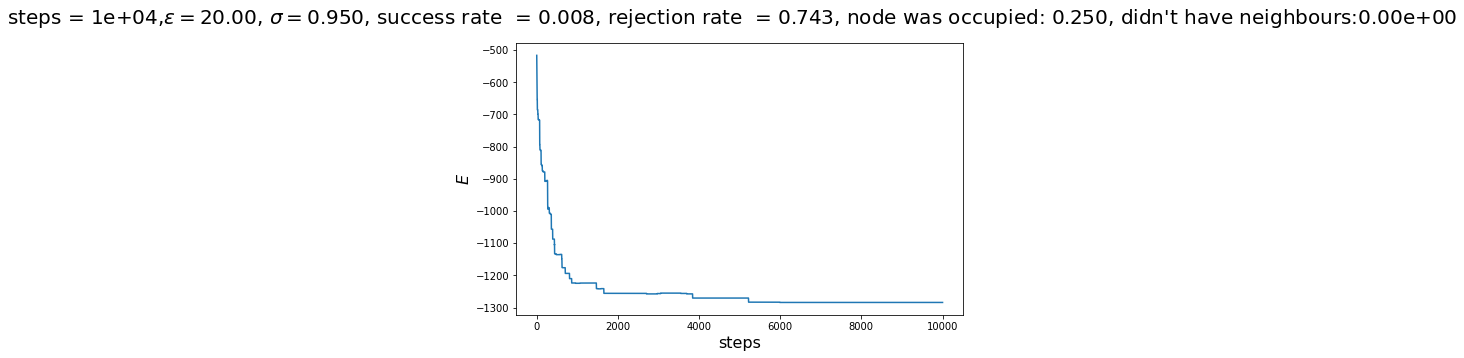

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -45.0661
E_end = -81.1225


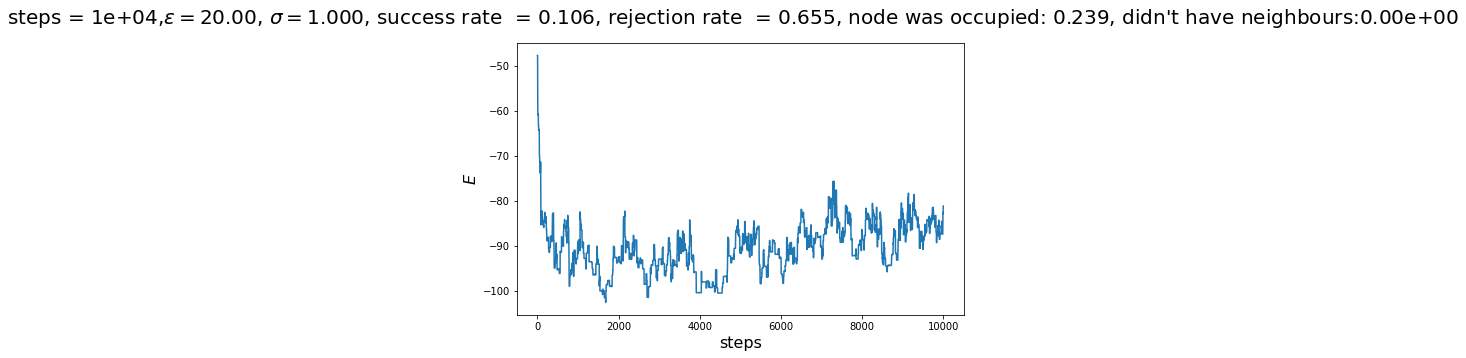

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 1070.1896
E_end = -111.7167


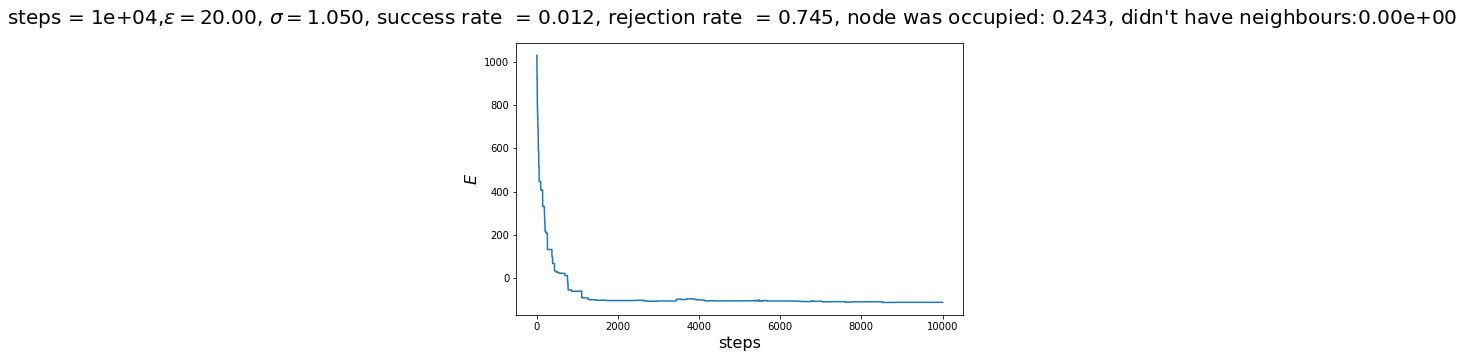

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 3310.8815
E_end = -135.2594


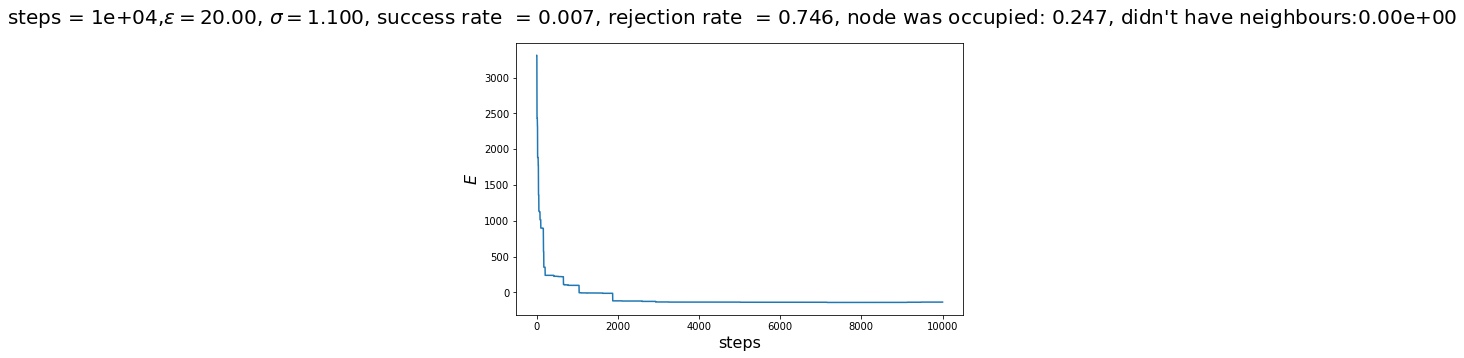

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 7429.9616
E_end = -194.0550


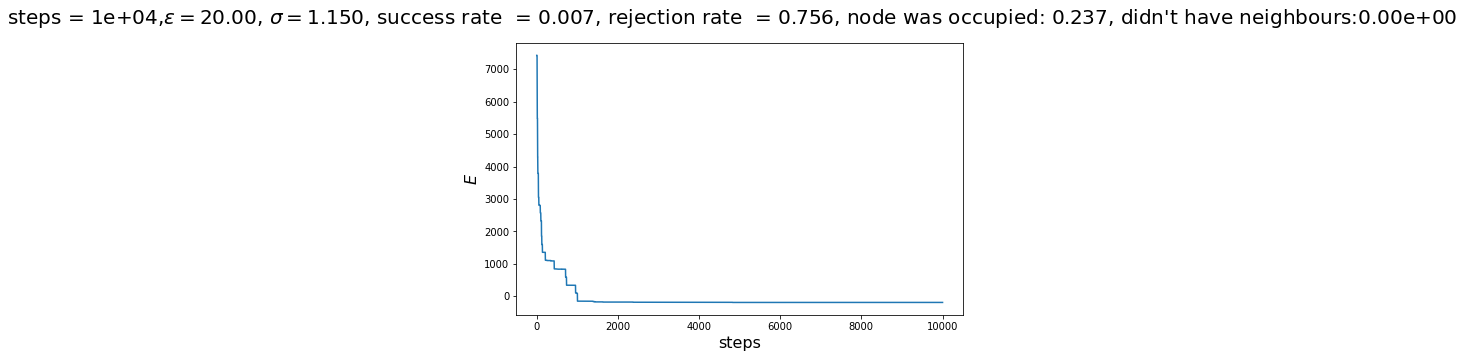

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 14575.9738
E_end = -221.8947


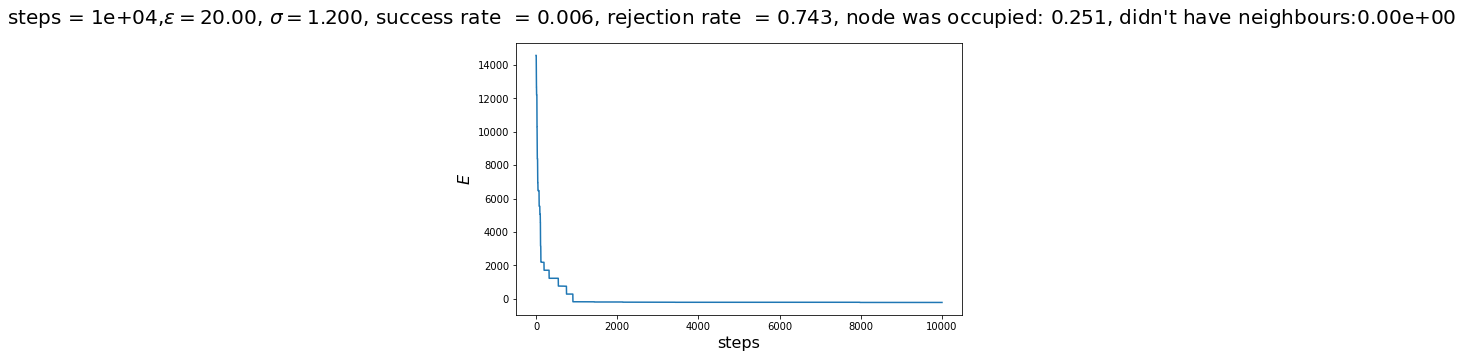

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 26463.3610
E_end = -308.1649


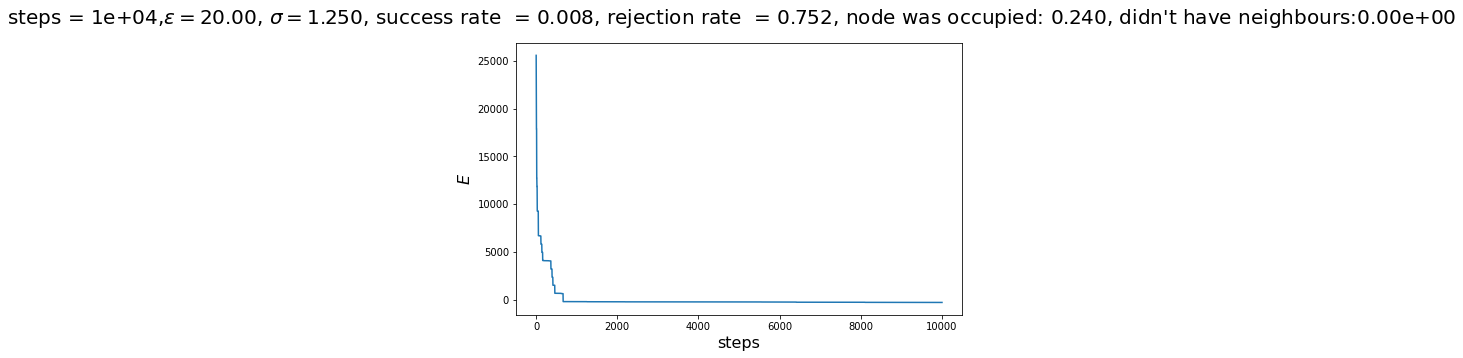

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 45603.2368
E_end = -355.7088


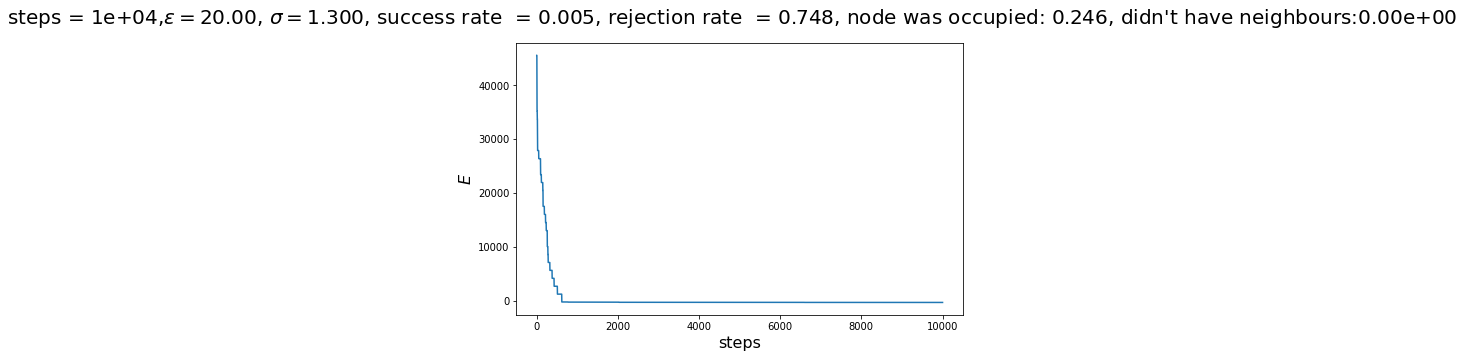

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 75612.1314
E_end = -448.0517


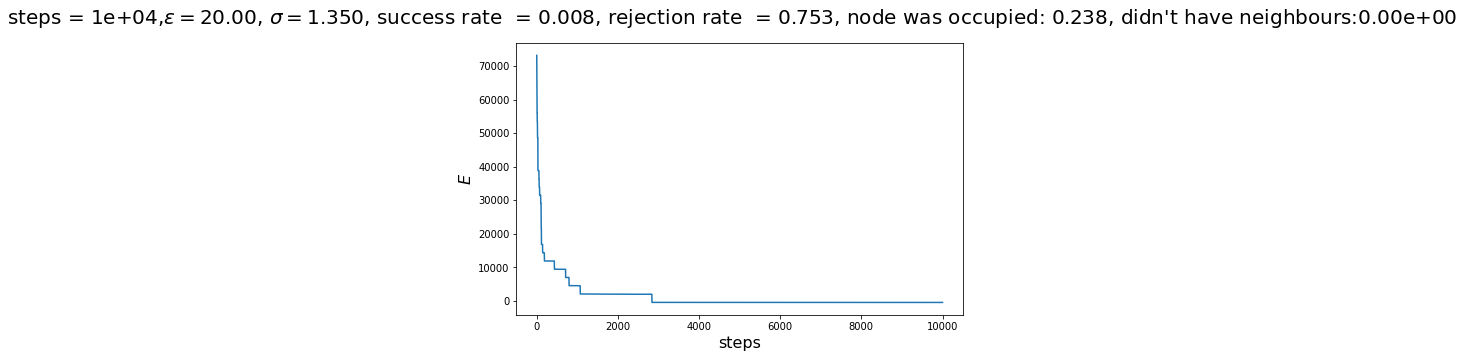

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 121620.2600
E_end = -533.4844


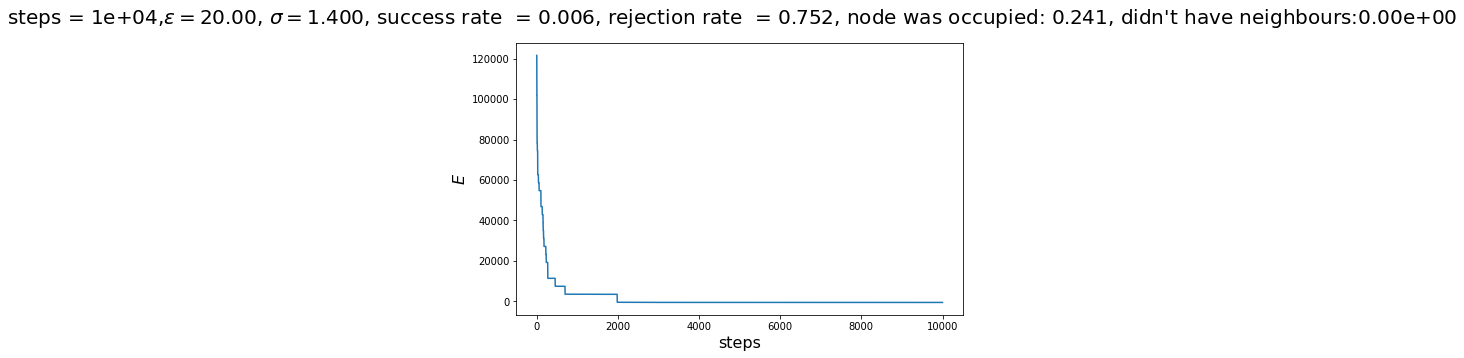

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 190805.6108
E_end = -686.1980


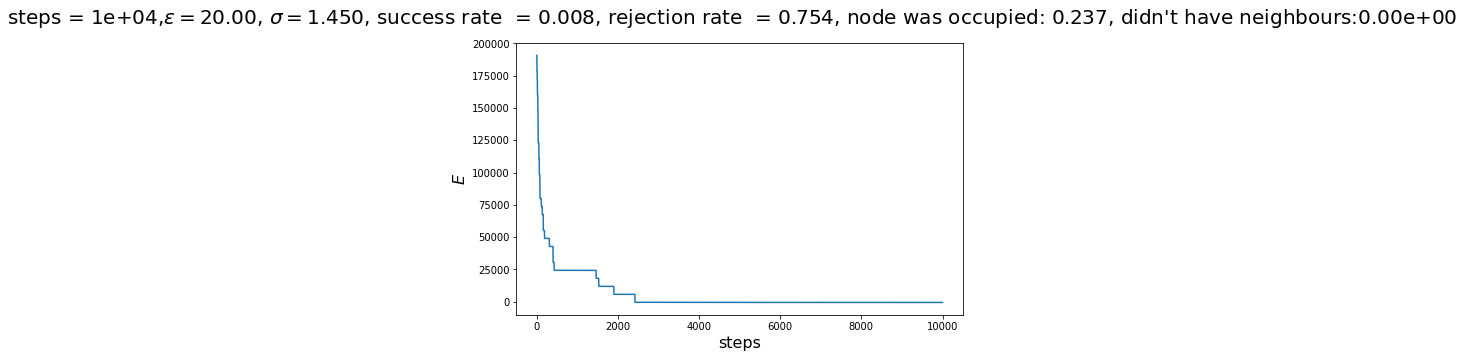

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 293085.7119
E_end = -751.8264


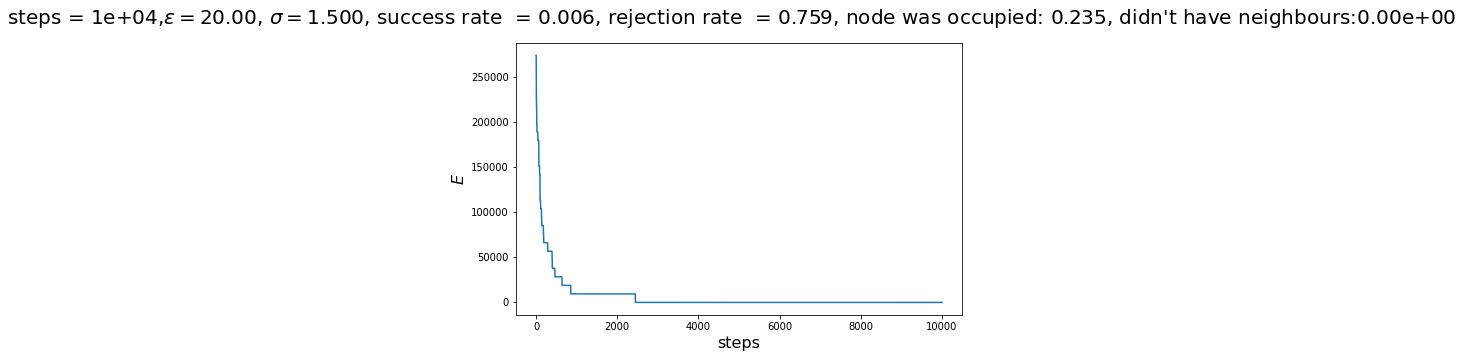

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 442005.3878
E_end = -861.0917


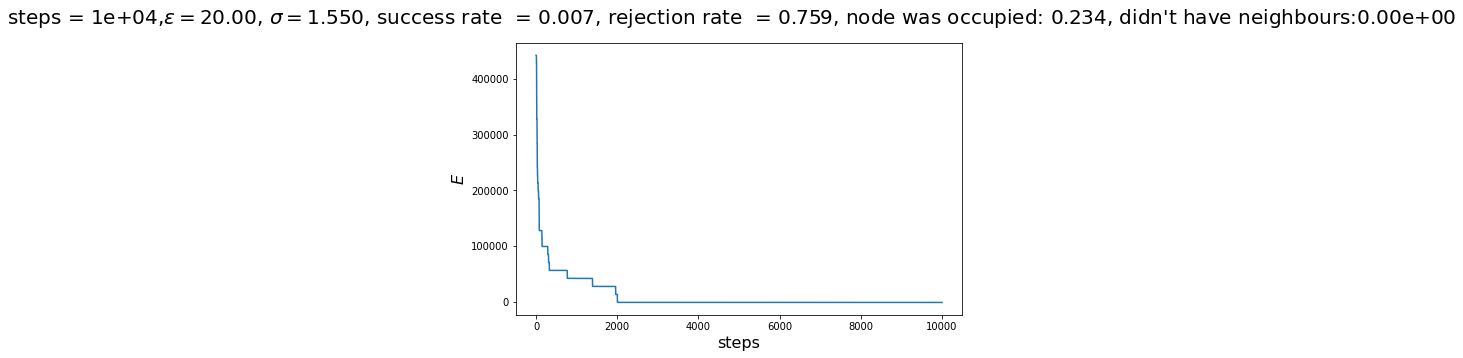

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 655866.2910
E_end = -936.5620


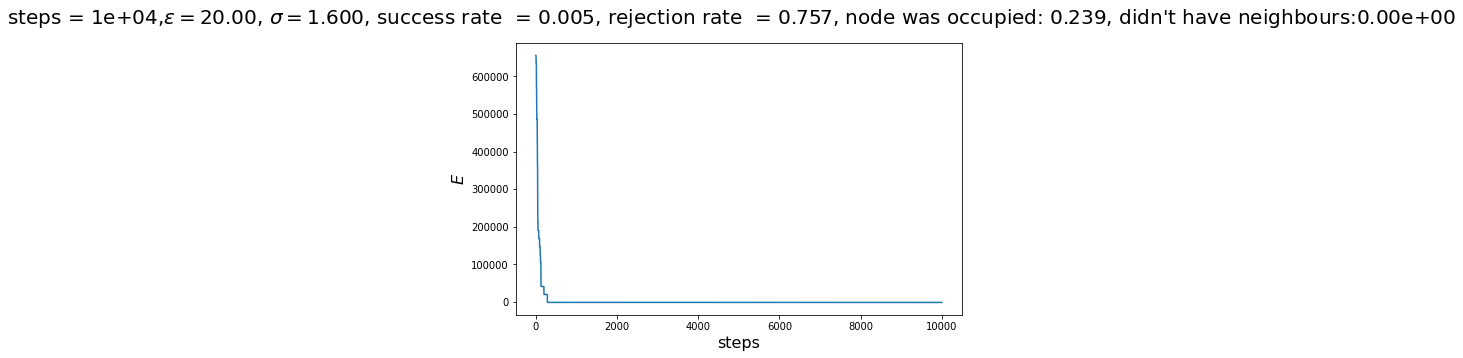

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 959152.5788
E_end = -1095.4246


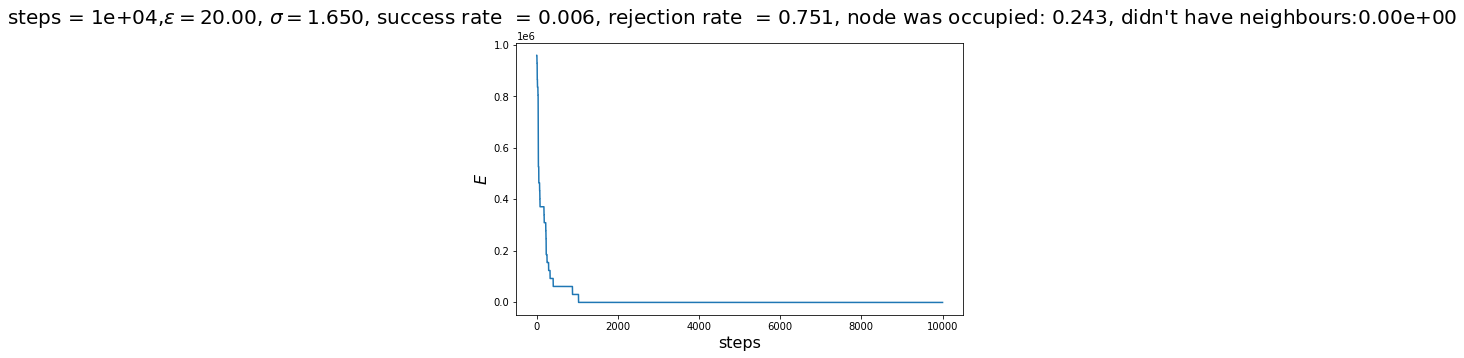

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 1384316.9420
E_end = -1212.5840


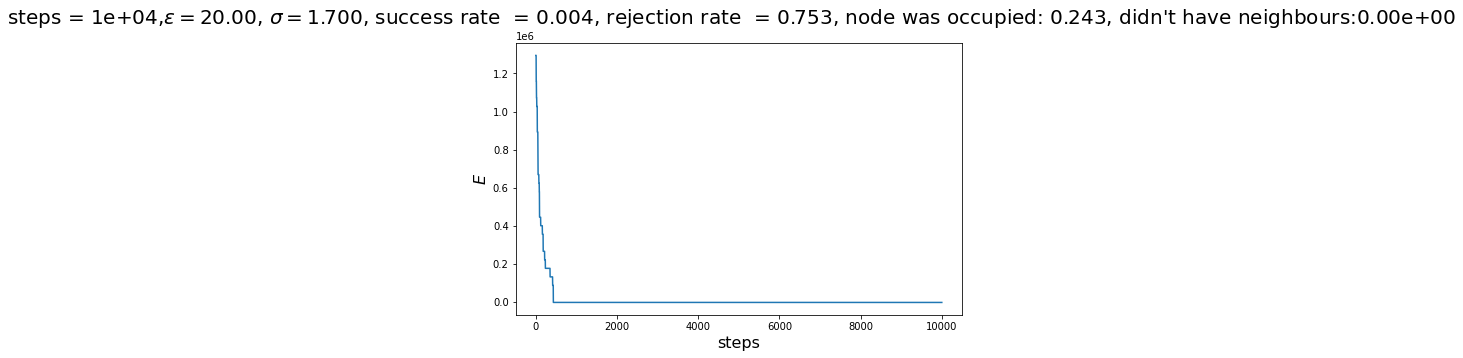

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 1974002.4019
E_end = -1376.3384


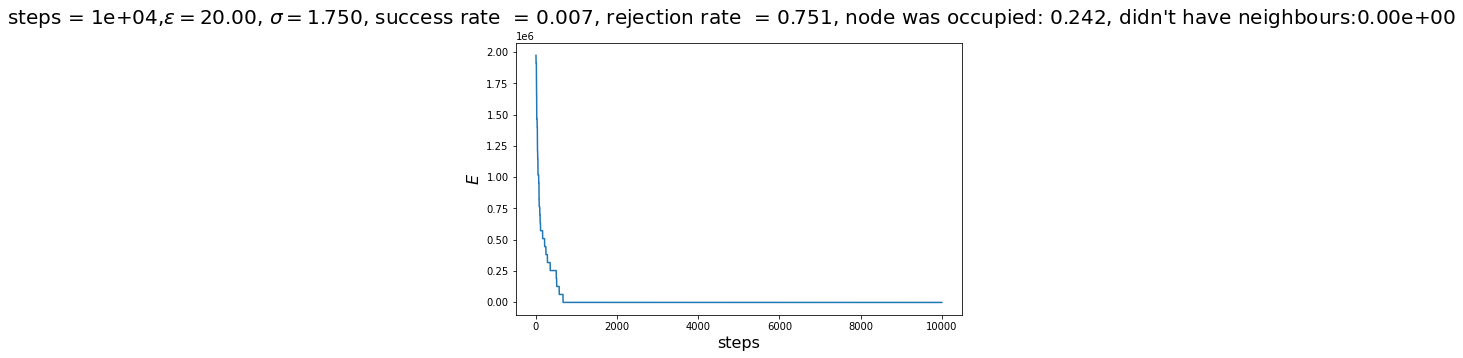

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 2783788.0141
E_end = -1326.0315


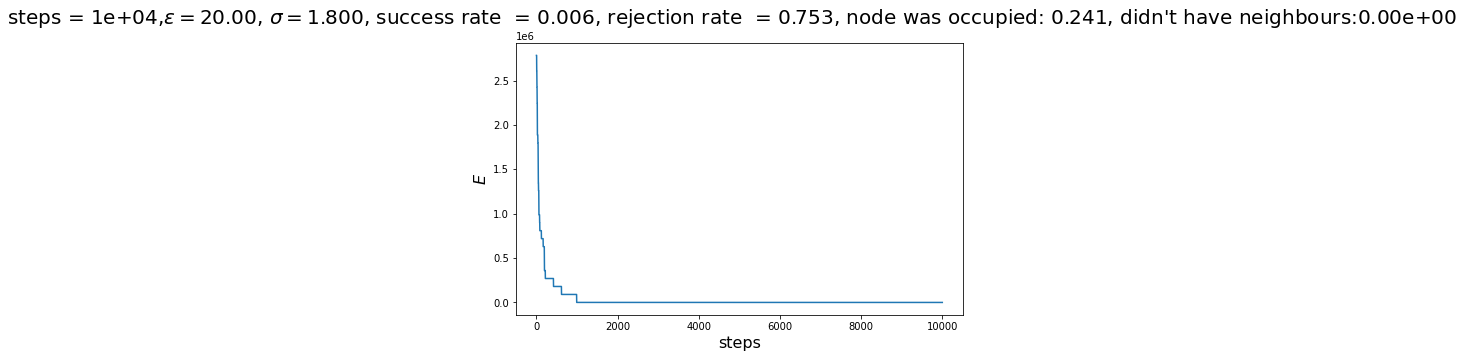

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 3885561.0074
E_end = -1101.3708


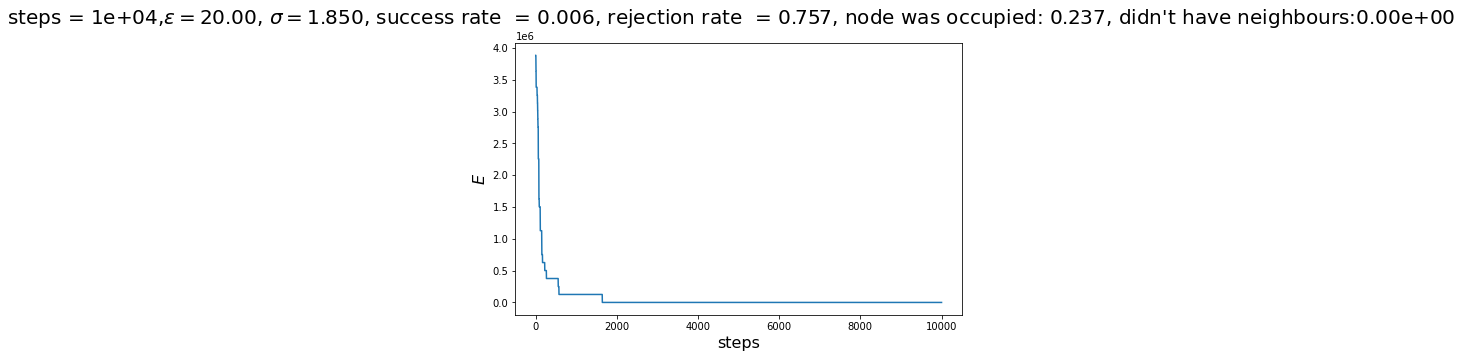

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 5371634.0923
E_end = -1209.8244


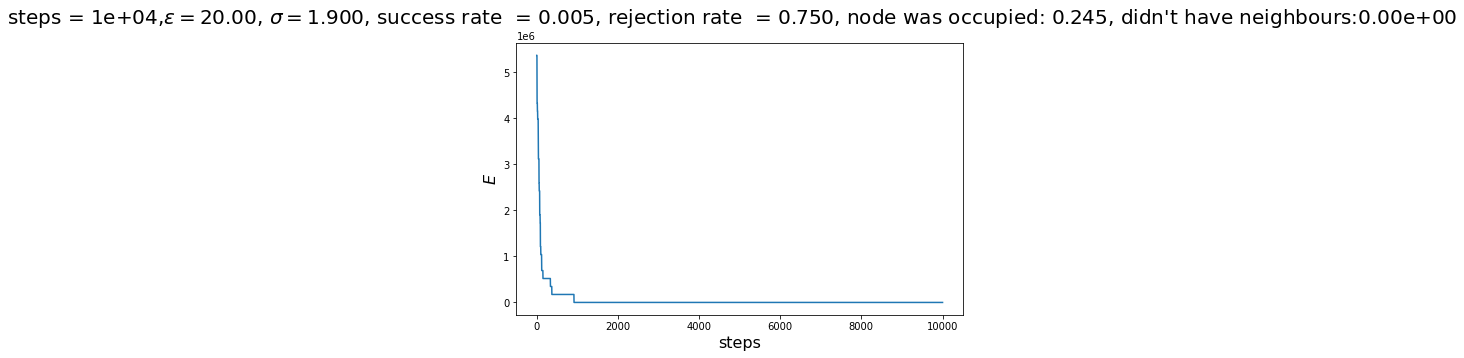

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 7359744.8740
E_end = -774.8080


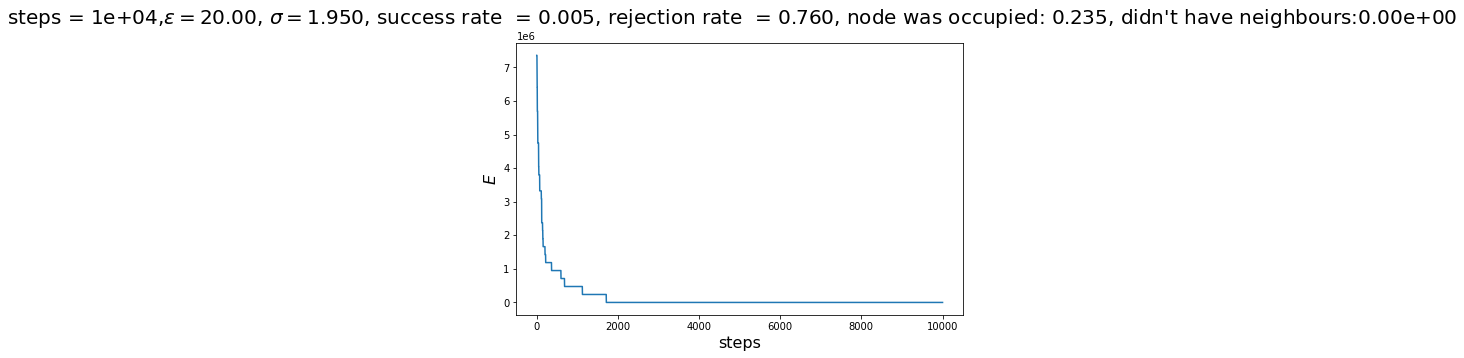

In [ ]:
steps = 10**4
eps = 20
Succ_rate = []
Rej_rate = []
N, adj, neighbors, particles_init, is_particle_init =\
        system_initialization(N = 100//4,maxweight = 10, size = 100)
sigma_range = np.arange(0, 2, 0.05)
for sigma in sigma_range:
    particles, is_particle = particles_init.copy(), is_particle_init.copy()
    with ProgressBar(total=steps) as progress:
        particles, is_particle, E_arr, time_arr, Statistic = simulation(progress, eps, sigma, N, adj, neighbors, particles, is_particle, steps)
    Succ_rate.append(Statistic[2])
    Rej_rate.append(Statistic[3])
    show_and_save_results(eps, sigma,E_arr, time_arr, Statistic, steps)

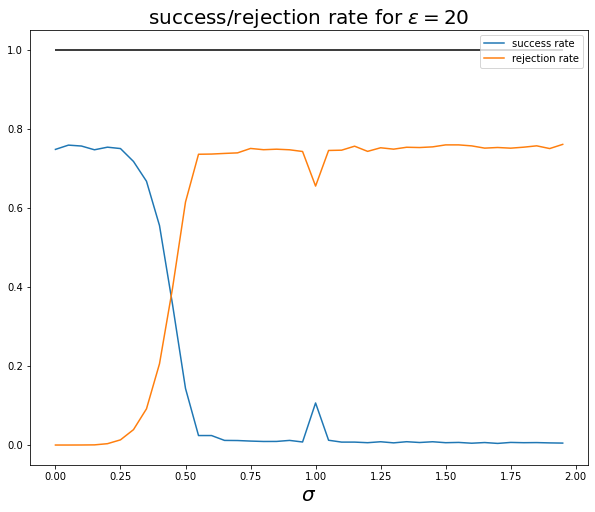

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(sigma_range, Succ_rate, label='success rate')
plt.plot(sigma_range, Rej_rate, label='rejection rate')
plt.hlines(1, sigma_range[0], sigma_range[-1])
plt.legend()
plt.xlabel(r'$\sigma$', fontsize=20)
plt.title(r'success/rejection rate for $\varepsilon=20$', fontsize=20)
plt.show()

#### Investigating a peak around $\sigma=1$

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -282.0504
E_end = -792.3649


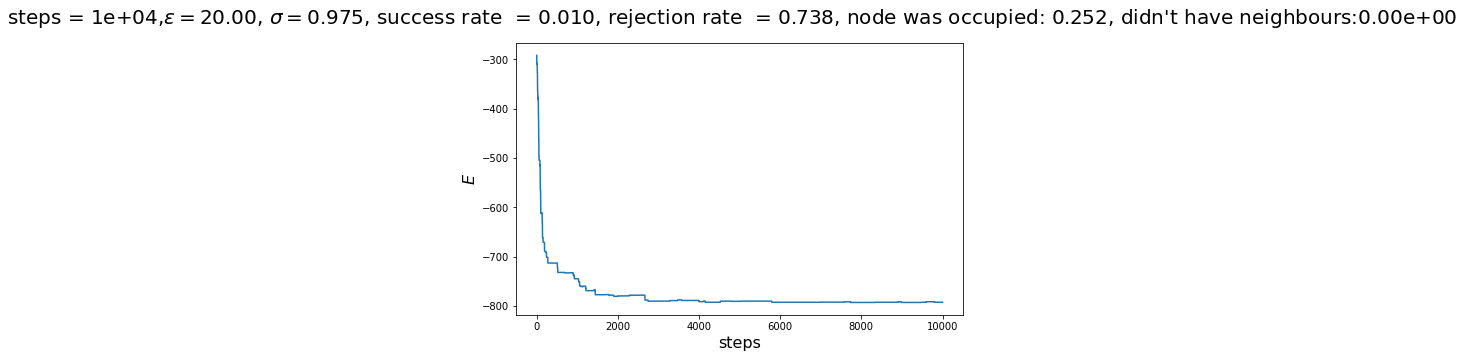

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -241.4965
E_end = -675.2864


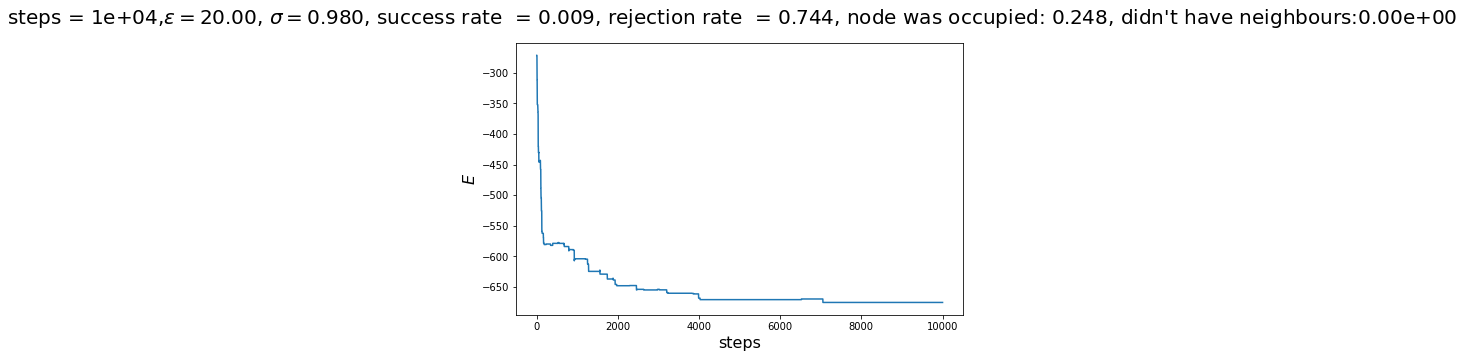

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -196.7954
E_end = -530.5086


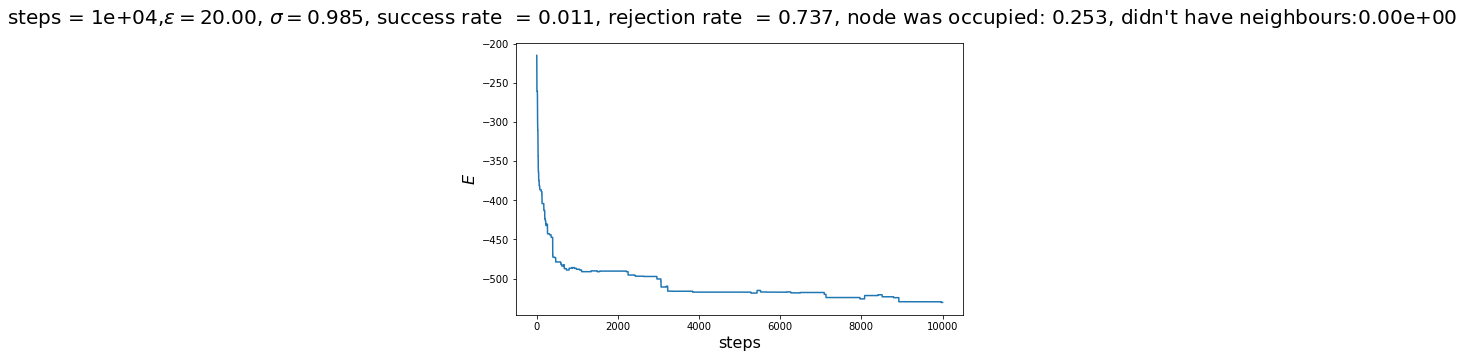

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -147.6843
E_end = -381.0931


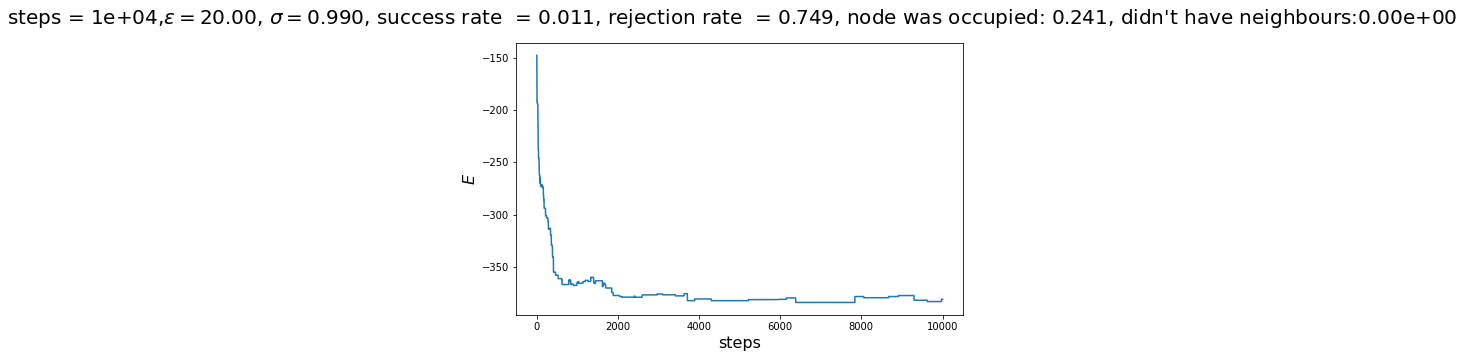

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -93.8870
E_end = -219.8993


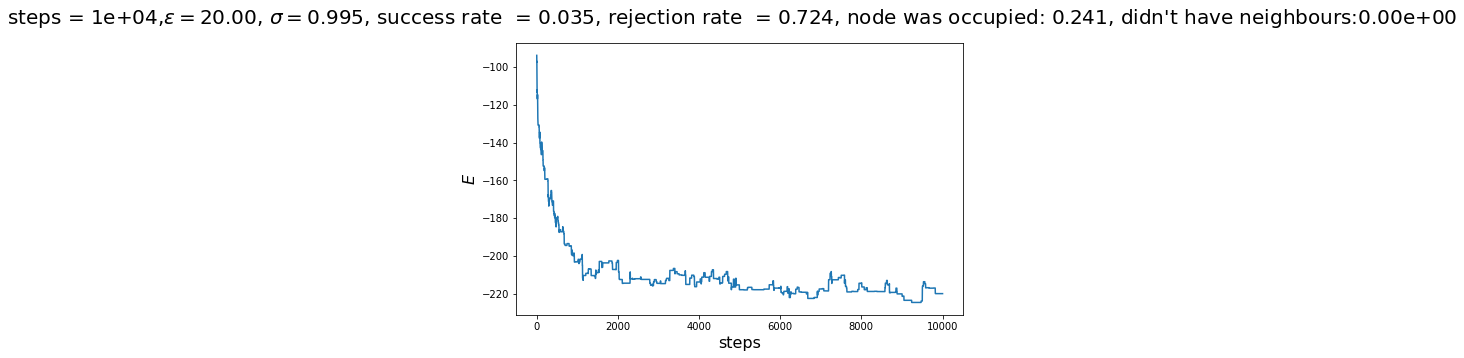

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = -35.1138
E_end = -84.2643


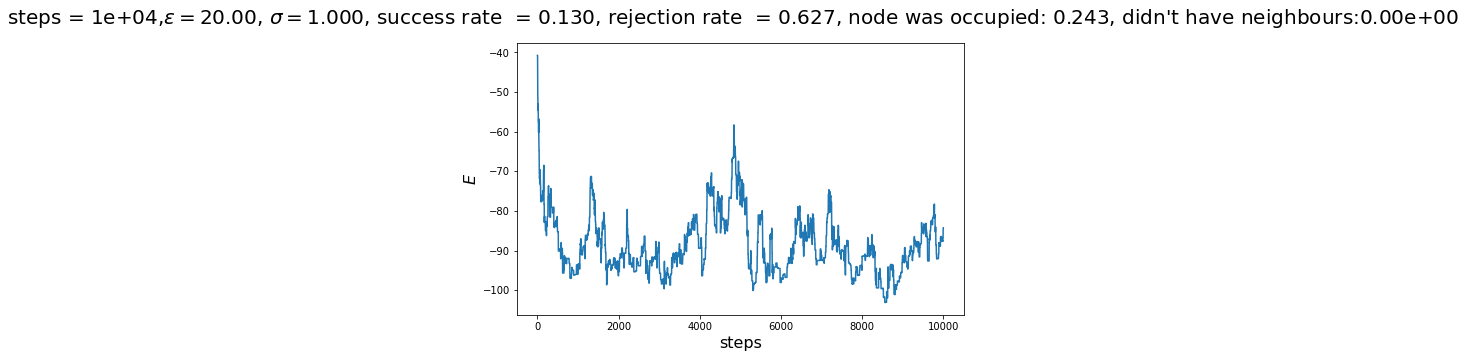

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 28.9396
E_end = -82.0946


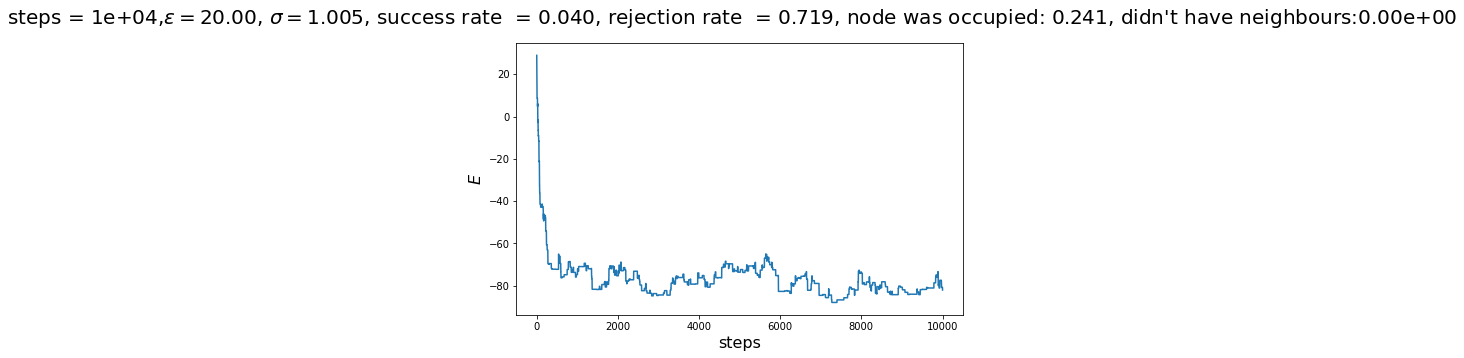

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 98.5924
E_end = -87.5914


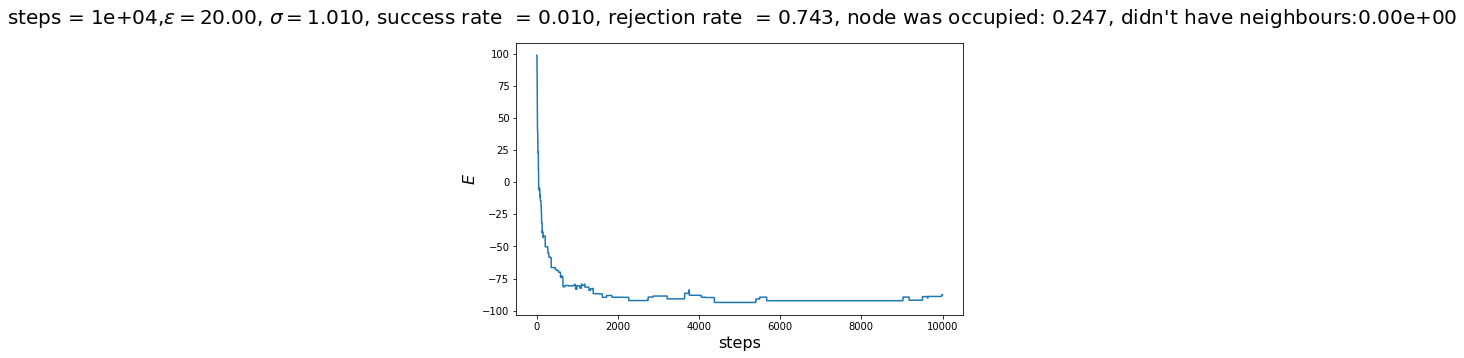

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 174.1793
E_end = -86.3237


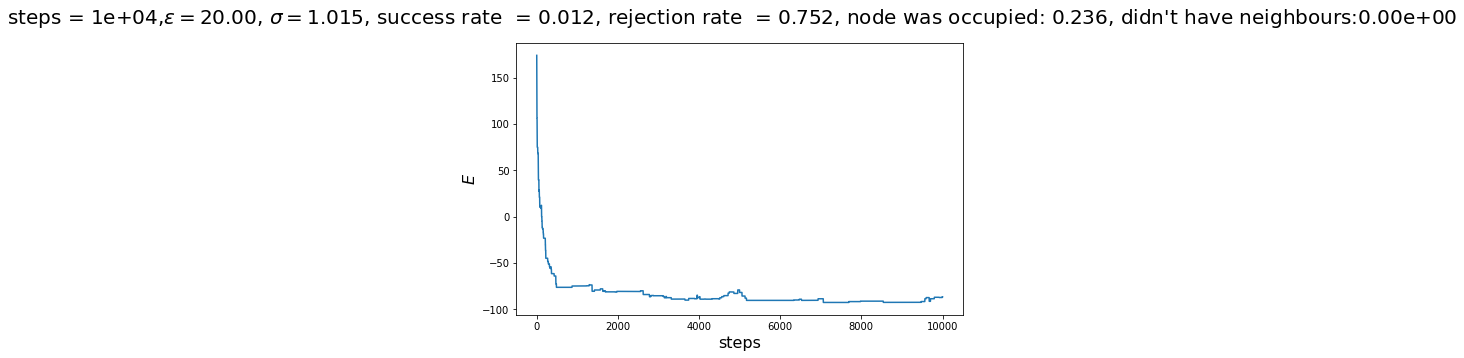

  0%|          | 0/10000 [00:00<?, ?it/s]


E_start = 256.0514
E_end = -94.0532


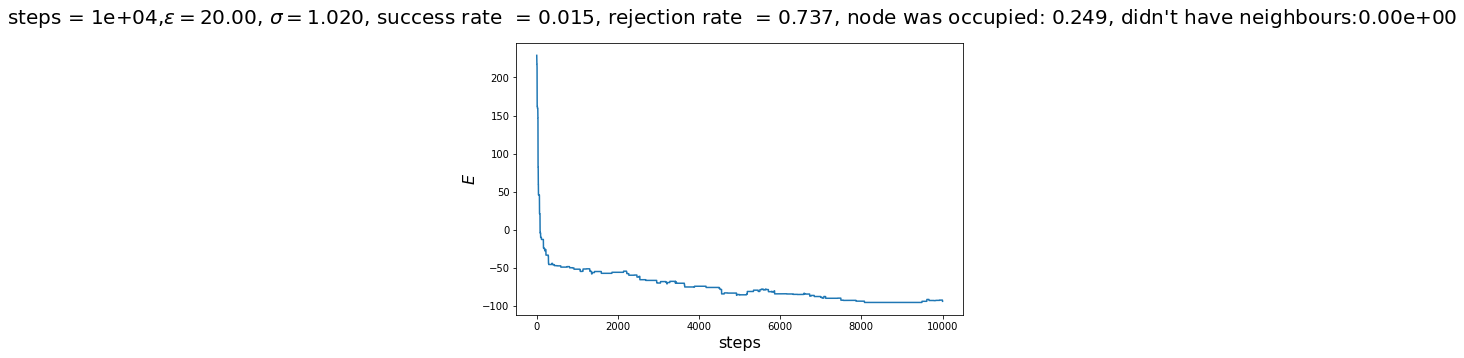

In [ ]:
steps = 10**4
eps = 20
Succ_rate = []
Rej_rate = []
N, adj, neighbors, particles_init, is_particle_init =\
        system_initialization(N = 100//4,maxweight = 10, size = 100)
sigma_range = np.arange(0.975,1.025, 0.005)
for sigma in sigma_range:
    particles, is_particle = particles_init.copy(), is_particle_init.copy()
    with ProgressBar(total=steps) as progress:
        particles, is_particle, E_arr, time_arr, Statistic = simulation(progress, eps, sigma, N, adj, neighbors, particles, is_particle, steps)
    Succ_rate.append(Statistic[2])
    Rej_rate.append(Statistic[3])
    show_and_save_results(eps, sigma,E_arr, time_arr, Statistic, steps)

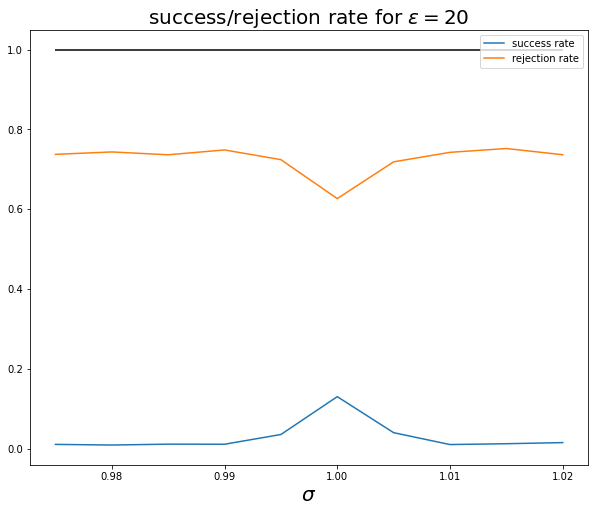

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(sigma_range, Succ_rate, label='success rate')
plt.plot(sigma_range, Rej_rate, label='rejection rate')
plt.hlines(1, sigma_range[0], sigma_range[-1])
plt.legend()
plt.xlabel(r'$\sigma$', fontsize=20)
plt.title(r'success/rejection rate for $\varepsilon=20$', fontsize=20)
plt.show()